<a href="https://colab.research.google.com/github/Evans2424/inception-analysis/blob/main/inception_analysis_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INCEpTION Annotations Exploratory Data Analysis
## Comprehensive Analysis of Portuguese Municipal Documents

**Objective**: Provide statistical foundations and publication-ready visualizations for academic research on Named Entity Recognition (NER) systems applied to Portuguese municipal governance documents.

**Dataset**: 120+ manually annotated documents from multiple Portuguese municipalities using the INCEpTION annotation platform.

**Analysis Focus**:
- Entity type distributions and characteristics
- Posicionamento (voting positioning) patterns
- Assunto analysis
- Cross-municipality comparisons

---

In [1]:
!git clone https://github.com/Evans2424/inception-analysis.git
%cd inception-analysis

fatal: destination path 'inception-analysis' already exists and is not an empty directory.
/content/inception-analysis


In [2]:
# Jupyter configuration for optimal display
%matplotlib inline

# Verify environment
import sys
print(f"Python: {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Running in: {'Jupyter' if 'ipykernel' in sys.modules else 'Standard Python'}")
print("✅ Jupyter magic commands loaded")

Python: 3.12.11
Running in: Jupyter
✅ Jupyter magic commands loaded


## 1. Setup and Data Loading

In [3]:
# Import core libraries
import pandas as pd
import numpy as np
import json
from pathlib import Path
from collections import Counter, defaultdict
import warnings

# Data analysis and statistics
from scipy import stats
from scipy.stats import chi2_contingency, kruskal, mannwhitneyu

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configure warnings
warnings.filterwarnings('ignore')

# Import custom utilities
sys.path.append('./utils')
from inception_parser import InceptionParser
from analysis_functions import AnnotationAnalyzer, calculate_effect_size, bootstrap_confidence_interval
from figure_utils import save_figure, save_html_only, setup_colab_kaleido

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
px.defaults.template = "plotly_white"
px.defaults.color_continuous_scale = "viridis"

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully")
print(f"📊 Analysis environment ready")
print(f"📅 Analysis date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🖼️ Matplotlib backend: {matplotlib.get_backend()}")
print("💾 Colab-friendly figure utilities loaded")

✅ All libraries imported successfully
📊 Analysis environment ready
📅 Analysis date: 2025-09-06 01:59:39
🖼️ Matplotlib backend: module://matplotlib_inline.backend_inline
💾 Colab-friendly figure utilities loaded


In [4]:
# Data paths
INCEPTION_DATA_DIR = Path('./inception')
RESULTS_DIR = Path('./results')
FIGURES_DIR = RESULTS_DIR / 'figures'
STATISTICS_DIR = RESULTS_DIR / 'statistics'

# Create directories
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
STATISTICS_DIR.mkdir(parents=True, exist_ok=True)

print(f"📂 Data directory: {INCEPTION_DATA_DIR}")
print(f"📊 Results will be saved to: {RESULTS_DIR}")

# Check data availability
json_files = list(INCEPTION_DATA_DIR.glob('*.json'))
print(f"📄 Found {len(json_files)} INCEpTION JSON files")

if len(json_files) == 0:
    print("⚠️ No JSON files found. Please check the data directory path.")
else:
    print("✅ Data files detected")
    print(f"📋 Sample files: {[f.name for f in json_files[:5]]}")

📂 Data directory: inception
📊 Results will be saved to: results
📄 Found 120 INCEpTION JSON files
✅ Data files detected
📋 Sample files: ['Fundao_cm_014_2021-12-11.json', 'Covilha_cm_003-A_2021-11-19.json', 'Porto_cm_036_2023-05-08.json', 'Guimaraes_cm_010_2023-05-25.json', 'Covilha_cm_021_2024-12-12.json']


In [5]:
# Configure figure saving for Colab compatibility
print("🔧 Configuring figure saving...")
SAVE_HTML = True  # Always save HTML (works in all environments)
SAVE_IMAGES = False  # Disable PNG exports by default (can cause issues in Colab)

# Uncomment the next line if you want to try setting up Kaleido for image exports
# setup_colab_kaleido()

print(f"💾 HTML export: {'✅ Enabled' if SAVE_HTML else '❌ Disabled'}")
print(f"🖼️ PNG export: {'✅ Enabled' if SAVE_IMAGES else '❌ Disabled (Colab-friendly)'}")
print("💡 Change SAVE_IMAGES to True if you need PNG exports and have Kaleido working")

🔧 Configuring figure saving...
💾 HTML export: ✅ Enabled
🖼️ PNG export: ❌ Disabled (Colab-friendly)
💡 Change SAVE_IMAGES to True if you need PNG exports and have Kaleido working


## 2. Data Parsing and Preprocessing

In [6]:
# Initialize the INCEpTION parser
print("🔄 Initializing INCEpTION parser...")
parser = InceptionParser()

# Parse all documents
print("🔄 Parsing INCEpTION annotation files...")
documents = parser.parse_directory(INCEPTION_DATA_DIR)

# Get parsing summary
summary = parser.get_parsing_summary()

print(f"\n=== PARSING RESULTS ===")
print(f"📊 Documents successfully parsed: {summary['total_documents_parsed']}")
print(f"⚠️ Parsing errors: {summary['parsing_errors']}")
print(f"🏛️ Municipalities: {len(summary['municipalities'])}")
print(f"📋 Municipality list: {', '.join(summary['municipalities'])}")
print(f"🏷️ Total entities: {summary['total_entities']:,}")
print(f"🔗 Total relations: {summary['total_relations']:,}")

if summary['parsing_errors'] > 0:
    print(f"\n⚠️ Error details:")
    for error in summary['error_details'][:5]:  # Show first 5 errors
        print(f"  - {error['file']}: {error['error']}")

print("\n✅ Data parsing completed")

🔄 Initializing INCEpTION parser...
🔄 Parsing INCEpTION annotation files...

=== PARSING RESULTS ===
📊 Documents successfully parsed: 120
⚠️ Parsing errors: 0
🏛️ Municipalities: 6
📋 Municipality list: Alandroal, Fundao, Campomaior, Covilha, Porto, Guimaraes
🏷️ Total entities: 26,435
🔗 Total relations: 8,741

✅ Data parsing completed


In [7]:
# Create analysis DataFrames
print("🔄 Creating analysis DataFrames...")

entities_df = parser.create_entity_dataframe()  # Uses parser.parsed_documents by default
relations_df = parser.create_relations_dataframe()  # Uses parser.parsed_documents by default
documents_df = parser.create_document_dataframe()  # Uses parser.parsed_documents by default

# Filter out empty entity types (annotation artifacts)
if not entities_df.empty:
    initial_count = len(entities_df)
    # Remove entities with empty, null, or whitespace-only labels
    entities_df = entities_df[
        (entities_df['entity_label'].notna()) &
        (entities_df['entity_label'] != '') &
        (entities_df['entity_label'].str.strip() != '')
    ].copy()
    filtered_count = len(entities_df)
    removed_count = initial_count - filtered_count

    if removed_count > 0:
        print(f"🧹 Filtered out {removed_count:,} entities with empty labels (annotation artifacts)")
    else:
        print("✅ No empty entity labels found")

print(f"✅ DataFrames created successfully:")
print(f"   • Entities: {len(entities_df):,} rows")
print(f"   • Relations: {len(relations_df):,} rows")
print(f"   • Documents: {len(documents_df):,} rows")

# Initialize the AnnotationAnalyzer
print("\n🔄 Initializing AnnotationAnalyzer...")
analyzer = AnnotationAnalyzer(entities_df, relations_df, documents_df)
print("✅ AnnotationAnalyzer ready for comprehensive analysis")

🔄 Creating analysis DataFrames...
🧹 Filtered out 6 entities with empty labels (annotation artifacts)
✅ DataFrames created successfully:
   • Entities: 26,429 rows
   • Relations: 8,741 rows
   • Documents: 120 rows

🔄 Initializing AnnotationAnalyzer...
✅ AnnotationAnalyzer ready for comprehensive analysis


In [8]:
# Preview the data structure
print("👀 Data Preview")
print("\n=== ENTITIES DATAFRAME ===")
print(entities_df.head())
print(f"\nColumns: {list(entities_df.columns)}")

print("\n=== RELATIONS DATAFRAME ===")
print(relations_df.head())
print(f"\nColumns: {list(relations_df.columns)}")

print("\n=== DOCUMENTS DATAFRAME ===")
print(documents_df.head())
print(f"\nColumns: {list(documents_df.columns)}")

👀 Data Preview

=== ENTITIES DATAFRAME ===
                        filename municipality    document_id        date  \
0  Fundao_cm_014_2021-12-11.json       Fundao  Fundao_cm_014  2021-12-11   
1  Fundao_cm_014_2021-12-11.json       Fundao  Fundao_cm_014  2021-12-11   
2  Fundao_cm_014_2021-12-11.json       Fundao  Fundao_cm_014  2021-12-11   
3  Fundao_cm_014_2021-12-11.json       Fundao  Fundao_cm_014  2021-12-11   
4  Fundao_cm_014_2021-12-11.json       Fundao  Fundao_cm_014  2021-12-11   

   entity_id  entity_type entity_label  begin  end                    text  \
0         77  custom.Span    Metadados     96  103                 14/2021   
1         78  custom.Span    Metadados    115  124               ordinária   
2         79  custom.Span    Metadados    142  164  12 de novembro de 2021   
3         80  custom.Span    Metadados    178  189             16:30 horas   
4         81  custom.Span    Metadados    205  210                   18:00   

   ...  feature_Fronteira  meta

## 3. Corpus Overview & Statistics

In [9]:
# Run comprehensive analysis
print("🔬 Running comprehensive statistical analysis...")

try:
    comprehensive_analysis = analyzer.run_comprehensive_analysis()

    # Save results using enhanced JSON serialization
    results_file = RESULTS_DIR / "comprehensive_analysis.json"

    # Enhanced JSON serializer for complex objects
    def make_json_serializable(obj):
        """Recursively convert objects to JSON-serializable format."""
        if isinstance(obj, dict):
            # Handle dictionary keys that might be tuples or other non-string types
            new_dict = {}
            for k, v in obj.items():
                # Convert tuple keys to strings
                if isinstance(k, tuple):
                    key = str(k)
                elif isinstance(k, (int, float, bool)):
                    key = str(k)
                else:
                    key = k
                new_dict[key] = make_json_serializable(v)
            return new_dict
        elif isinstance(obj, (list, tuple)):
            return [make_json_serializable(item) for item in obj]
        elif isinstance(obj, set):
            return list(obj)
        elif hasattr(obj, '__dict__'):
            return str(obj)
        elif isinstance(obj, (int, float, str, bool, type(None))):
            return obj
        else:
            return str(obj)

    # Convert to JSON-serializable format
    serializable_analysis = make_json_serializable(comprehensive_analysis)

    with open(results_file, 'w', encoding='utf-8') as f:
        json.dump(serializable_analysis, f, indent=2, ensure_ascii=False)

    print("✅ Comprehensive analysis completed successfully!")

    # Display basic overview
    print("\n=== ANALYSIS OVERVIEW ===")
    if 'corpus_statistics' in comprehensive_analysis:
        corpus_stats = comprehensive_analysis['corpus_statistics']
        if 'corpus_overview' in corpus_stats:
            overview = corpus_stats['corpus_overview']
            print(f"📚 Total Documents: {overview.get('total_documents', 0):,}")
            print(f"🏛️ Municipalities: {overview.get('total_municipalities', 0)}")
            print(f"📝 Total Entities: {corpus_stats.get('entity_overview', {}).get('total_entities', 0):,}")
            print(f"🔗 Total Relations: {corpus_stats.get('relation_overview', {}).get('total_relations', 0):,}")

    print(f"\n📊 Results saved to: {results_file}")

    # Extract corpus statistics for display
    corpus_stats = comprehensive_analysis['corpus_statistics']['corpus_overview']
    entity_stats = comprehensive_analysis['corpus_statistics'].get('entity_overview', {})
    relation_stats = comprehensive_analysis['corpus_statistics'].get('relation_overview', {})

    # Calculate averages
    total_docs = corpus_stats['total_documents']
    avg_tokens_per_doc = corpus_stats['total_tokens'] / total_docs if total_docs > 0 else 0
    avg_entities_per_doc = entity_stats.get('total_entities', 0) / total_docs if total_docs > 0 else 0

    # Create comprehensive statistics table
    stats_data = [
        ['📄 Total Documents', f"{corpus_stats['total_documents']:,}"],
        ['🏛️ Municipalities', f"{corpus_stats['total_municipalities']}"],
        ['📋 Documents/Municipality', '20'],
        ['📊 Total Text Length', f"{corpus_stats['total_text_length']:,} characters"],
        ['🔤 Total Tokens', f"{corpus_stats['total_tokens']:,}"],
        ['📊 Avg Tokens/Document', f"{round(avg_tokens_per_doc):,}"],
        ['🏷️ Total Entities', f"{entity_stats.get('total_entities', 0):,}"],
        ['📋 Avg Entities/Document', f"{round(avg_entities_per_doc):,}"],
        ['📝 Entity Types', f"{entity_stats.get('unique_entity_types', 0)}"],
        ['🔗 Total Relations', f"{relation_stats.get('total_relations', 0):,}"],
        ['📈 Documents with Entities', f"{entity_stats.get('documents_with_entities', 0):,}"],
        ['📊 Entity Coverage', f"{entity_stats.get('entity_coverage', 0):.1%}"]
    ]

    # Display as formatted table
    stats_df = pd.DataFrame(stats_data, columns=['Metric', 'Value'])
    print("\n=== CORPUS OVERVIEW STATISTICS ===")
    print(stats_df.to_string(index=False))

    # Save statistics table
    stats_df.to_csv(STATISTICS_DIR / 'corpus_overview_table.csv', index=False)
    print(f"\n💾 Statistics table saved to {STATISTICS_DIR / 'corpus_overview_table.csv'}")

except Exception as e:
    print(f"❌ Error during analysis: {str(e)}")
    import traceback
    traceback.print_exc()

🔬 Running comprehensive statistical analysis...
✅ Comprehensive analysis completed successfully!

=== ANALYSIS OVERVIEW ===
📚 Total Documents: 120
🏛️ Municipalities: 6
📝 Total Entities: 26,429
🔗 Total Relations: 8,741

📊 Results saved to: results/comprehensive_analysis.json

=== CORPUS OVERVIEW STATISTICS ===
                   Metric                Value
        📄 Total Documents                  120
        🏛️ Municipalities                    6
 📋 Documents/Municipality                   20
      📊 Total Text Length 7,512,427 characters
           🔤 Total Tokens            1,188,024
    📊 Avg Tokens/Document                9,900
        🏷️ Total Entities               26,429
  📋 Avg Entities/Document                  220
           📝 Entity Types                    5
        🔗 Total Relations                8,741
📈 Documents with Entities                  120
        📊 Entity Coverage               100.0%

💾 Statistics table saved to results/statistics/corpus_overview_table.csv


## 4. Entity Type Analysis

In [10]:
# Entity type distribution analysis
if not entities_df.empty:
    entity_type_counts = entities_df['entity_label'].value_counts()
    entity_type_percentages = (entity_type_counts / entity_type_counts.sum() * 100).round(2)

    print("=== ENTITY TYPE DISTRIBUTION ===")
    for entity_type, count in entity_type_counts.items():
        percentage = entity_type_percentages[entity_type]
        print(f"{entity_type}: {count:,} ({percentage:.1f}%)")

    # Define consistent color palette (Set3) - vibrant but not overwhelming
    import plotly.colors
    entity_types = list(entity_type_counts.index)
    color_palette = plotly.colors.qualitative.Set3[:len(entity_types)]

    # Create combined visualization
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Entity Type Frequencies', 'Entity Type Distribution'),
        specs=[[{'type': 'bar'}, {'type': 'pie'}]]
    )

    # Bar chart with balanced colors
    fig.add_trace(
        go.Bar(x=entity_type_counts.index, y=entity_type_counts.values, name='Count',
               marker_color=color_palette),
        row=1, col=1
    )

    # Pie chart with balanced colors
    fig.add_trace(
        go.Pie(labels=entity_type_counts.index, values=entity_type_counts.values, name='Distribution',
               marker_colors=color_palette),
        row=1, col=2
    )

    fig.update_layout(
        title_text="🏷️ Entity Type Analysis",
        height=500,
        showlegend=True
    )

    fig.show()

    # Save figure
    # Save figure using Colab-friendly utility
    save_figure(
        fig,
        'entity_type_analysis',
        FIGURES_DIR,
        save_html=SAVE_HTML,
        save_image=SAVE_IMAGES,
        width=1200,
        height=600
    )

else:
    print("⚠️ No entities found in the dataset")

=== ENTITY TYPE DISTRIBUTION ===
Posicionamento: 8,777 (33.2%)
Assunto: 8,647 (32.7%)
Informação Pessoal: 5,760 (21.8%)
Metadados: 1,825 (6.9%)
Ordem do Dia: 1,420 (5.4%)


💾 Saved HTML: results/figures/entity_type_analysis.html


In [11]:
# Analysis of entities and relations by municipality
print("=== ENTITIES AND RELATIONS BY MUNICIPALITY ===")

if not entities_df.empty:
    # Group entities by municipality
    entities_by_municipality = entities_df.groupby('municipality').agg({
        'entity_id': 'count',  # Count of entities
        'entity_label': lambda x: x.value_counts().to_dict()  # Entity type distribution per municipality
    }).rename(columns={'entity_id': 'total_entities'})

    print("\n📊 ENTITY COUNTS BY MUNICIPALITY:")
    entities_by_municipality_sorted = entities_by_municipality.sort_values('total_entities', ascending=False)

    for municipality, row in entities_by_municipality_sorted.iterrows():
        total_entities = row['total_entities']
        print(f"\n🏛️ {municipality}: {total_entities:,} entities")

        # Show entity type breakdown for this municipality
        entity_types = row['entity_label']
        for entity_type, count in sorted(entity_types.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / total_entities) * 100
            print(f"   • {entity_type}: {count:,} ({percentage:.1f}%)")

if not relations_df.empty:
    # Group relations by municipality
    relations_by_municipality = relations_df.groupby('municipality').agg({
        'relation_id': 'count',  # Count of relations
        'relation_type': lambda x: x.value_counts().to_dict()  # Relation type distribution per municipality
    }).rename(columns={'relation_id': 'total_relations'})

    print("\n\n🔗 RELATION COUNTS BY MUNICIPALITY:")
    relations_by_municipality_sorted = relations_by_municipality.sort_values('total_relations', ascending=False)

    for municipality, row in relations_by_municipality_sorted.iterrows():
        total_relations = row['total_relations']
        print(f"\n🏛️ {municipality}: {total_relations:,} relations")

        # Show relation type breakdown for this municipality
        relation_types = row['relation_type']
        for relation_type, count in sorted(relation_types.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / total_relations) * 100
            print(f"   • {relation_type}: {count:,} ({percentage:.1f}%)")

# Create visualization combining entities and relations by municipality
if not entities_df.empty or not relations_df.empty:
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Entities by Municipality', 'Relations by Municipality',
            'Entity Density (per Document)', 'Relation Density (per Document)'
        ),
        specs=[[{'type': 'bar'}, {'type': 'bar'}],
               [{'type': 'bar'}, {'type': 'bar'}]]
    )

    # Entities by municipality
    if not entities_df.empty:
        entity_counts = entities_by_municipality_sorted['total_entities']
        fig.add_trace(
            go.Bar(
                x=entity_counts.index,
                y=entity_counts.values,
                name='Entities',
                marker_color='lightblue'
            ),
            row=1, col=1
        )

        # Calculate entity density (entities per document)
        if not documents_df.empty:
            doc_counts_by_municipality = documents_df['municipality'].value_counts()
            entity_density = entity_counts / doc_counts_by_municipality.reindex(entity_counts.index)

            fig.add_trace(
                go.Bar(
                    x=entity_density.index,
                    y=entity_density.values,
                    name='Entity Density',
                    marker_color='lightgreen'
                ),
                row=2, col=1
            )

    # Relations by municipality
    if not relations_df.empty:
        relation_counts = relations_by_municipality_sorted['total_relations']
        fig.add_trace(
            go.Bar(
                x=relation_counts.index,
                y=relation_counts.values,
                name='Relations',
                marker_color='lightcoral'
            ),
            row=1, col=2
        )

        # Calculate relation density (relations per document)
        if not documents_df.empty:
            doc_counts_by_municipality = documents_df['municipality'].value_counts()
            relation_density = relation_counts / doc_counts_by_municipality.reindex(relation_counts.index)

            fig.add_trace(
                go.Bar(
                    x=relation_density.index,
                    y=relation_density.values,
                    name='Relation Density',
                    marker_color='lightyellow'
                ),
                row=2, col=2
            )

    fig.update_layout(
        title_text="🏛️ Entities and Relations Distribution by Municipality",
        height=800,
        showlegend=False
    )

    # Rotate x-axis labels for better readability
    fig.update_xaxes(tickangle=-45)

    fig.show()

    # Save figure
    # Save figure using Colab-friendly utility
    save_figure(
        fig,
        'entities_relations_by_municipality',
        FIGURES_DIR,
        save_html=SAVE_HTML,
        save_image=SAVE_IMAGES,
        width=1400,
        height=800
    )

    print(f"\n💾 Municipality analysis visualization saved")

# Create stacked bar chart for entity types by municipality
if not entities_df.empty:
    print("\n📊 Creating stacked bar chart for entity types by municipality...")

    # Create a cross-tabulation of municipalities and entity types
    entity_muni_cross = pd.crosstab(entities_df['municipality'], entities_df['entity_label'])

    # Sort municipalities by total entity count for consistent ordering
    entity_muni_cross = entity_muni_cross.loc[entities_by_municipality_sorted.index]

    # Create stacked bar chart
    fig_entity_types = go.Figure()

    # Get distinct colors for each entity type
    entity_types = entity_muni_cross.columns.tolist()
    colors = px.colors.qualitative.Set3[:len(entity_types)]

    # Add traces for each entity type
    for i, entity_type in enumerate(entity_types):
        fig_entity_types.add_trace(
            go.Bar(
                name=entity_type,
                x=entity_muni_cross.index,
                y=entity_muni_cross[entity_type],
                marker_color=colors[i % len(colors)]
            )
        )

    fig_entity_types.update_layout(
        title='🏷️ Entity Types Distribution by Municipality (Stacked)',
        xaxis_title='Municipality',
        yaxis_title='Number of Entities',
        barmode='stack',
        height=600,
        xaxis_tickangle=-45,
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1.02
        )
    )

    fig_entity_types.show()

    # Save the stacked bar chart
    save_figure(
        fig_entity_types,
        'entity_types_by_municipality_stacked',
        FIGURES_DIR,
        save_html=SAVE_HTML,
        save_image=SAVE_IMAGES,
        width=1200,
        height=600
    )

    print(f"💾 Entity types stacked bar chart saved")

    # Print summary of entity type distribution
    print(f"\n📈 ENTITY TYPE DISTRIBUTION SUMMARY:")
    total_by_type = entity_muni_cross.sum().sort_values(ascending=False)
    print(f"• Total entity types found: {len(entity_types)}")
    print(f"• Most common entity type: {total_by_type.index[0]} ({total_by_type.iloc[0]:,} entities)")
    print(f"• Least common entity type: {total_by_type.index[-1]} ({total_by_type.iloc[-1]:,} entities)")

    # Show top entity types across all municipalities
    print(f"\n🏆 TOP ENTITY TYPES (across all municipalities):")
    for entity_type, count in total_by_type.head(10).items():
        percentage = (count / total_by_type.sum()) * 100
        print(f"   • {entity_type}: {count:,} ({percentage:.1f}%)")

# Summary statistics
if not entities_df.empty and not relations_df.empty:
    print(f"\n📈 SUMMARY STATISTICS:")
    print(f"• Total municipalities with entities: {len(entities_by_municipality)}")
    print(f"• Total municipalities with relations: {len(relations_by_municipality)}")
    print(f"• Average entities per municipality: {entities_by_municipality['total_entities'].mean():.1f}")
    print(f"• Average relations per municipality: {relations_by_municipality['total_relations'].mean():.1f}")

    # Find municipalities with highest/lowest counts
    max_entities_mun = entities_by_municipality['total_entities'].idxmax()
    min_entities_mun = entities_by_municipality['total_entities'].idxmin()
    max_relations_mun = relations_by_municipality['total_relations'].idxmax()
    min_relations_mun = relations_by_municipality['total_relations'].idxmin()

    print(f"\n🏆 Municipality with most entities: {max_entities_mun} ({entities_by_municipality.loc[max_entities_mun, 'total_entities']:,})")
    print(f"🏆 Municipality with most relations: {max_relations_mun} ({relations_by_municipality.loc[max_relations_mun, 'total_relations']:,})")
    print(f"📉 Municipality with fewest entities: {min_entities_mun} ({entities_by_municipality.loc[min_entities_mun, 'total_entities']:,})")
    print(f"📉 Municipality with fewest relations: {min_relations_mun} ({relations_by_municipality.loc[min_relations_mun, 'total_relations']:,})")

=== ENTITIES AND RELATIONS BY MUNICIPALITY ===

📊 ENTITY COUNTS BY MUNICIPALITY:

🏛️ Covilha: 6,122 entities
   • Posicionamento: 2,201 (36.0%)
   • Assunto: 2,159 (35.3%)
   • Informação Pessoal: 1,289 (21.1%)
   • Metadados: 305 (5.0%)
   • Ordem do Dia: 168 (2.7%)

🏛️ Campomaior: 4,993 entities
   • Informação Pessoal: 2,297 (46.0%)
   • Assunto: 1,192 (23.9%)
   • Posicionamento: 1,124 (22.5%)
   • Metadados: 264 (5.3%)
   • Ordem do Dia: 116 (2.3%)

🏛️ Guimaraes: 4,674 entities
   • Posicionamento: 1,679 (35.9%)
   • Assunto: 1,662 (35.6%)
   • Informação Pessoal: 928 (19.9%)
   • Metadados: 366 (7.8%)
   • Ordem do Dia: 39 (0.8%)

🏛️ Porto: 4,208 entities
   • Posicionamento: 1,715 (40.8%)
   • Assunto: 1,416 (33.7%)
   • Ordem do Dia: 463 (11.0%)
   • Metadados: 370 (8.8%)
   • Informação Pessoal: 244 (5.8%)

🏛️ Alandroal: 3,915 entities
   • Assunto: 1,513 (38.6%)
   • Posicionamento: 1,306 (33.4%)
   • Informação Pessoal: 458 (11.7%)
   • Ordem do Dia: 399 (10.2%)
   • Metadad

💾 Saved HTML: results/figures/entities_relations_by_municipality.html

💾 Municipality analysis visualization saved

📊 Creating stacked bar chart for entity types by municipality...


💾 Saved HTML: results/figures/entity_types_by_municipality_stacked.html
💾 Entity types stacked bar chart saved

📈 ENTITY TYPE DISTRIBUTION SUMMARY:
• Total entity types found: 5
• Most common entity type: Posicionamento (8,777 entities)
• Least common entity type: Ordem do Dia (1,420 entities)

🏆 TOP ENTITY TYPES (across all municipalities):
   • Posicionamento: 8,777 (33.2%)
   • Assunto: 8,647 (32.7%)
   • Informação Pessoal: 5,760 (21.8%)
   • Metadados: 1,825 (6.9%)
   • Ordem do Dia: 1,420 (5.4%)

📈 SUMMARY STATISTICS:
• Total municipalities with entities: 6
• Total municipalities with relations: 6
• Average entities per municipality: 4404.8
• Average relations per municipality: 1456.8

🏆 Municipality with most entities: Covilha (6,122)
🏆 Municipality with most relations: Covilha (2,192)
📉 Municipality with fewest entities: Fundao (2,517)
📉 Municipality with fewest relations: Fundao (740)


In [12]:
# Entity length and characteristics analysis
if not entities_df.empty:
    # Entity length distribution
    fig_length = px.histogram(
        entities_df,
        x='length',
        nbins=30,
        title='📏 Entity Length Distribution (Characters)',
        labels={'length': 'Entity Length (characters)', 'count': 'Frequency'},
        marginal='box'  # Add box plot
    )

    fig_length.update_layout(height=500)
    fig_length.show()

    # Token count distribution
    fig_tokens = px.histogram(
        entities_df,
        x='token_count',
        nbins=20,
        title='🔤 Entity Token Count Distribution',
        labels={'token_count': 'Token Count', 'count': 'Frequency'},
        marginal='violin'  # Add violin plot
    )

    fig_tokens.update_layout(height=500)
    fig_tokens.show()

    # Length by entity type
    fig_length_by_type = px.box(
        entities_df,
        x='entity_label',
        y='length',
        title='📊 Entity Length Distribution by Type',
        labels={'entity_label': 'Entity Type', 'length': 'Length (characters)'},
        points='outliers'
    )

    fig_length_by_type.update_layout(
        xaxis_tickangle=-45,
        height=500
    )

    fig_length_by_type.show()

    # Save figures
    fig_length.write_html(FIGURES_DIR / 'entity_length_distribution.html')
    fig_tokens.write_html(FIGURES_DIR / 'entity_token_distribution.html')
    fig_length_by_type.write_html(FIGURES_DIR / 'entity_length_by_type.html')

    print("💾 Entity characteristics visualizations saved")

💾 Entity characteristics visualizations saved


### 4.1 Statistical Significance Testing

This sub-section presents statistical tests to determine whether the observed differences in entity type distributions and characteristics across municipalities are statistically significant.

In [13]:
# Statistical Significance Testing for Entity Type Analysis
print("=== STATISTICAL SIGNIFICANCE TESTS FOR ENTITY TYPE ANALYSIS ===")

# Import required libraries for statistical testing
from scipy.stats import chi2_contingency, kruskal, f_oneway
import numpy as np

# 1. Chi-square test for entity type distribution across municipalities
if not entities_df.empty and len(entities_df['municipality'].unique()) > 1:
    print("\n1. 🧮 Chi-square Test for Entity Type Distribution Across Municipalities")

    # Create contingency table
    contingency_table = pd.crosstab(entities_df['municipality'], entities_df['entity_label'])

    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
        chi2, p_val, dof, expected = chi2_contingency(contingency_table)

        # Cramér's V (effect size for chi-square)
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

        print(f"   Chi-square statistic: {chi2:.4f}")
        if p_val == 0.0:
            print(f"   p-value: < 1e-323 (reported as 0.0 due to numerical precision)")
            print(f"   📝 Note: p-value = 0 indicates extremely strong evidence against null hypothesis")
        else:
            print(f"   p-value: {p_val:.6f}")
        print(f"   Degrees of freedom: {dof}")
        print(f"   Cramér's V (effect size): {cramers_v:.4f}")

        if p_val < 0.05 or p_val == 0.0:
            print(f"   ✅ SIGNIFICANT: Entity type distributions differ significantly across municipalities")
            if cramers_v < 0.1:
                print("   📊 Effect size: Very small")
            elif cramers_v < 0.3:
                print("   📊 Effect size: Small")
            elif cramers_v < 0.5:
                print("   📊 Effect size: Medium")
            else:
                print("   📊 Effect size: Large")
        else:
            print(f"   ❌ NOT SIGNIFICANT: No significant differences in entity type distributions")
    else:
        print("   ⚠️ Insufficient data for chi-square test")

# 2. ANOVA/Kruskal-Wallis test for entity counts by municipality
if not entities_df.empty and len(entities_df['municipality'].unique()) > 1:
    print("\n2. 📊 Test for Entity Count Differences Across Municipalities")

    # Group entity counts by municipality
    entity_counts_by_muni = entities_df.groupby('municipality').size()

    if len(entity_counts_by_muni) > 2:
        # Use Kruskal-Wallis as it's more robust for count data
        try:
            h_stat, p_kruskal = kruskal(*[entities_df[entities_df['municipality'] == muni].shape[0]
                                        for muni in entity_counts_by_muni.index if
                                        entities_df[entities_df['municipality'] == muni].shape[0] > 0])

            if not np.isnan(h_stat):
                print(f"   Kruskal-Wallis H-statistic: {h_stat:.4f}")
                print(f"   p-value: {p_kruskal:.6f}")

                if p_kruskal < 0.05:
                    print("   ✅ SIGNIFICANT (Kruskal-Wallis): Entity counts differ significantly across municipalities")
                else:
                    print("   ❌ NOT SIGNIFICANT (Kruskal-Wallis): No significant differences in entity counts")
            else:
                print("   ⚠️ Unable to compute test statistic")
        except Exception as e:
            print(f"   ⚠️ Error in statistical test: {e}")
    else:
        print("   ⚠️ Need at least 3 municipalities for this test")
# 3. Kruskal-Wallis test for entity length differences by type
if not entities_df.empty and len(entities_df['entity_label'].unique()) > 1:
    print("\n3. 📏 Kruskal-Wallis Test for Entity Length Differences by Type")

    # Group lengths by entity type
    length_groups = [group['length'].values for name, group in entities_df.groupby('entity_label')]

    if len(length_groups) > 1 and all(len(group) > 0 for group in length_groups):
        h_stat, p_kw = kruskal(*length_groups)

        print(f"   Kruskal-Wallis H-statistic: {h_stat:.4f}")
        print(f"   p-value: {p_kw:.6f}")

        if p_kw < 0.05:
            print("   ✅ SIGNIFICANT: Entity lengths differ significantly by entity type")
        else:
            print("   ❌ NOT SIGNIFICANT: No significant differences in entity lengths by type")
    else:
        print("   ⚠️ Insufficient data for length comparison test")

# 4. Test for entity density differences
if not entities_df.empty and not documents_df.empty:
    print("\n4. 📈 Test for Entity Density Differences Across Municipalities")

    # Calculate entity density (entities per document) by municipality
    doc_counts = documents_df['municipality'].value_counts()
    entity_counts = entities_df['municipality'].value_counts()
    density = entity_counts / doc_counts

    if len(density) > 2:
        # Use Kruskal-Wallis for density data
        try:
            h_stat, p_kruskal = kruskal(*[entities_df[entities_df['municipality'] == muni].shape[0] / doc_counts[muni]
                                        for muni in density.index if doc_counts[muni] > 0])

            if not np.isnan(h_stat):
                print(f"   Kruskal-Wallis H-statistic: {h_stat:.4f}")
                print(f"   p-value: {p_kruskal:.6f}")

                if p_kruskal < 0.05:
                    print("   ✅ SIGNIFICANT (Kruskal-Wallis): Entity density differs significantly across municipalities")
                else:
                    print("   ❌ NOT SIGNIFICANT (Kruskal-Wallis): No significant differences in entity density")
            else:
                print("   ⚠️ Unable to compute test statistic")
        except Exception as e:
            print(f"   ⚠️ Error in statistical test: {e}")
    else:
        print("   ⚠️ Need at least 3 municipalities for density test")
print("\n📋 SUMMARY OF STATISTICAL TESTS:")
print("   - Chi-square test: Tests if entity type proportions differ by municipality")
print("   - ANOVA/Kruskal-Wallis: Tests if entity counts/density differ by municipality")
print("   - Kruskal-Wallis: Tests if entity lengths differ by entity type")
print("   - p < 0.05 indicates statistically significant differences")
print("   - Effect sizes help interpret practical significance of findings")

print("\n💾 Statistical test results completed")

=== STATISTICAL SIGNIFICANCE TESTS FOR ENTITY TYPE ANALYSIS ===

1. 🧮 Chi-square Test for Entity Type Distribution Across Municipalities
   Chi-square statistic: 3494.0839
   p-value: < 1e-323 (reported as 0.0 due to numerical precision)
   📝 Note: p-value = 0 indicates extremely strong evidence against null hypothesis
   Degrees of freedom: 20
   Cramér's V (effect size): 0.1818
   ✅ SIGNIFICANT: Entity type distributions differ significantly across municipalities
   📊 Effect size: Small

2. 📊 Test for Entity Count Differences Across Municipalities
   Kruskal-Wallis H-statistic: 5.0000
   p-value: 0.415880
   ❌ NOT SIGNIFICANT (Kruskal-Wallis): No significant differences in entity counts

3. 📏 Kruskal-Wallis Test for Entity Length Differences by Type
   Kruskal-Wallis H-statistic: 3196.5596
   p-value: 0.000000
   ✅ SIGNIFICANT: Entity lengths differ significantly by entity type

4. 📈 Test for Entity Density Differences Across Municipalities
   Kruskal-Wallis H-statistic: 5.0000
   p-

## 5. Posicionamento Analysis (Voting Behavior) - Individual Time Pattern Plots

In [14]:
# Posicionamento analysis
if not relations_df.empty and 'posicionamento' in relations_df.columns:
    # Filter relations with posicionamento data
    pos_data = relations_df.dropna(subset=['posicionamento'])

    if not pos_data.empty:
        print("=== POSICIONAMENTO ANALYSIS ===")

        # Overall posicionamento distribution
        pos_counts = pos_data['posicionamento'].value_counts()
        pos_percentages = (pos_counts / pos_counts.sum() * 100).round(2)

        print("\nPositioning Distribution:")
        for pos, count in pos_counts.items():
            percentage = pos_percentages[pos]
            print(f"  {pos}: {count:,} ({percentage:.1f}%)")

        # Create visualization
        fig_pos = make_subplots(
            rows=1, cols=2,
            subplot_titles=('Posicionamento Frequencies', 'Posicionamento Distribution'),
            specs=[[{'type': 'bar'}, {'type': 'pie'}]]
        )

        # Use consistent color palette (Set3)
        colors = px.colors.qualitative.Set3[:len(pos_counts)]
        fig_pos.add_trace(
            go.Bar(x=pos_counts.index, y=pos_counts.values,
                   marker_color=colors, name='Count'),
            row=1, col=1
        )

        # Pie chart
        fig_pos.add_trace(
            go.Pie(labels=pos_counts.index, values=pos_counts.values,
                   marker_colors=colors, name='Distribution'),
            row=1, col=2
        )

        fig_pos.update_layout(
            title_text="🗳️ Posicionamento (Voting Position) Analysis",
            height=500,
            showlegend=False
        )

        fig_pos.show()

        # Save figure
        # Save figure using Colab-friendly utility
        save_figure(
            fig_pos,
            'posicionamento_analysis',
            FIGURES_DIR,
            save_html=SAVE_HTML,
            save_image=SAVE_IMAGES,
            width=1200,
            height=600
        )

    else:
        print("⚠️ No posicionamento data found")
else:
    print("⚠️ No relations or posicionamento column found")

=== POSICIONAMENTO ANALYSIS ===

Positioning Distribution:
  a favor: 2,643 (65.3%)
  abstenção: 1,103 (27.2%)
  contra: 198 (4.9%)
  não presente: 105 (2.6%)


💾 Saved HTML: results/figures/posicionamento_analysis.html


In [15]:
# Posicionamento by municipality analysis
if not relations_df.empty and 'posicionamento' in relations_df.columns:
    pos_data = relations_df.dropna(subset=['posicionamento'])

    if not pos_data.empty:
        # Cross-tabulation
        pos_muni_cross = pd.crosstab(pos_data['municipality'], pos_data['posicionamento'])

        # Normalize by municipality (percentage within each municipality)
        pos_muni_pct = pos_muni_cross.div(pos_muni_cross.sum(axis=1), axis=0) * 100

        # Create stacked bar chart
        fig_pos_muni = go.Figure()

        colors = px.colors.qualitative.Set3
        for i, pos_type in enumerate(pos_muni_cross.columns):
            fig_pos_muni.add_trace(go.Bar(
                name=pos_type,
                x=pos_muni_cross.index,
                y=pos_muni_cross[pos_type],
                marker_color=colors[i % len(colors)]
            ))

        fig_pos_muni.update_layout(
            title='🏛️ Posicionamento Distribution by Municipality',
            xaxis_title='Municipality',
            yaxis_title='Number of Positions',
            barmode='stack',
            xaxis_tickangle=-45,
            height=600
        )

        fig_pos_muni.show()

        # Create percentage heatmap
        fig_pos_heatmap = px.imshow(
            pos_muni_pct.values,
            x=pos_muni_pct.columns,
            y=pos_muni_pct.index,
            title='📊 Posicionamento Patterns by Municipality (%)',
            labels={'x': 'Position Type', 'y': 'Municipality', 'color': 'Percentage'},
            aspect='auto',
            color_continuous_scale='RdYlBu'
        )

        fig_pos_heatmap.update_layout(height=500)
        fig_pos_heatmap.show()

        # Save figures
        fig_pos_muni.write_html(FIGURES_DIR / 'posicionamento_by_municipality.html')
        fig_pos_heatmap.write_html(FIGURES_DIR / 'posicionamento_patterns_heatmap.html')

        print("💾 Posicionamento by municipality analysis saved")

💾 Posicionamento by municipality analysis saved


In [16]:
# Fix the posicionamento analysis visualization
print("=== POSICIONAMENTO ANALYSIS ===")

# Get posicionamento data
posicionamento_data = entities_df[entities_df['posicionamento'].notna()]

if not posicionamento_data.empty:
    import plotly.graph_objects as go
    import plotly.colors

    print("🗳️ Posicionamento (Voting Position) Analysis:")

    # Posicionamento distribution
    pos_counts = posicionamento_data['posicionamento'].value_counts()
    total_pos = len(posicionamento_data)

    print(f"\n📊 Position Distribution ({total_pos:,} total entities):")
    for pos_type, count in pos_counts.items():
        pct = (count / total_pos) * 100
        print(f"   {pos_type}: {count:,} ({pct:.1f}%)")

    # Define consistent color palette for all charts
    position_types = list(pos_counts.keys())
    color_palette = plotly.colors.qualitative.Set3[:len(position_types)]
    color_map = dict(zip(position_types, color_palette))

    # 1. Position Distribution - Individual Pie Chart
    print("\n📊 Position Distribution:")
    fig_pie = go.Figure(data=[
        go.Pie(
            labels=list(pos_counts.keys()),
            values=list(pos_counts.values),
            marker=dict(colors=[color_map[pos] for pos in pos_counts.keys()]),
            textinfo='label+percent',
            hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent}<extra></extra>'
        )
    ])

    fig_pie.update_layout(
        title="Position Distribution",
        height=500,
        showlegend=True
    )
    fig_pie.show()

    # Extract temporal patterns
    posicionamento_data_fixed = posicionamento_data.copy()

    def extract_date_info(filename):
        try:
            # Extract date from filename pattern like "Municipality_cm_XXX_YYYY-MM-DD.json"
            parts = filename.split('_')
            for part in parts:
                if len(part) >= 10 and '-' in part:  # Date part
                    date_part = part.split('.')[0]  # Remove .json
                    if len(date_part) >= 10:
                        return date_part
        except:
            pass
        return None

    posicionamento_data_fixed['date_str'] = posicionamento_data_fixed['filename'].apply(extract_date_info)
    posicionamento_data_fixed['date'] = pd.to_datetime(posicionamento_data_fixed['date_str'], errors='coerce')
    posicionamento_data_fixed = posicionamento_data_fixed.dropna(subset=['date'])

    # 2. Monthly Patterns - Individual Bar Chart
    print("\n📅 Monthly Patterns:")
    posicionamento_data_fixed['month'] = posicionamento_data_fixed['date'].dt.to_period('M')
    monthly_patterns = posicionamento_data_fixed.groupby(['month', 'posicionamento']).size().unstack(fill_value=0)

    fig_monthly = go.Figure()
    for pos_type in monthly_patterns.columns:
        fig_monthly.add_trace(
            go.Bar(
                x=[str(m) for m in monthly_patterns.index],
                y=list(monthly_patterns[pos_type]),
                name=pos_type,
                marker_color=color_map.get(pos_type, 'gray'),
                hovertemplate='<b>%{fullData.name}</b><br>Month: %{x}<br>Count: %{y}<extra></extra>'
            )
        )

    fig_monthly.update_layout(
        title="Monthly Position Patterns",
        xaxis_title="Month",
        yaxis_title="Number of Positions",
        height=600,
        barmode='stack',
        xaxis_tickangle=-45,
        showlegend=True
    )
    fig_monthly.show()

    # 3. Yearly Evolution - Individual Line Chart
    print("\n📈 Yearly Evolution:")
    posicionamento_data_fixed['year'] = posicionamento_data_fixed['date'].dt.year
    yearly_patterns = posicionamento_data_fixed.groupby(['year', 'posicionamento']).size().unstack(fill_value=0)

    fig_yearly = go.Figure()
    for pos_type in yearly_patterns.columns:
        fig_yearly.add_trace(
            go.Scatter(
                x=list(yearly_patterns.index),
                y=list(yearly_patterns[pos_type]),
                mode='lines+markers',
                name=pos_type,
                line=dict(color=color_map.get(pos_type, 'gray'), width=3),
                marker=dict(size=8),
                hovertemplate='<b>%{fullData.name}</b><br>Year: %{x}<br>Count: %{y}<extra></extra>'
            )
        )

    fig_yearly.update_layout(
        title="Yearly Position Evolution",
        xaxis_title="Year",
        yaxis_title="Number of Positions",
        height=500,
        showlegend=True
    )
    fig_yearly.show()

    # Save individual figures
    if 'FIGURES_DIR' in globals():
        fig_pie.write_html(FIGURES_DIR / 'posicionamento_distribution.html')
        fig_monthly.write_html(FIGURES_DIR / 'posicionamento_monthly_patterns.html')
        fig_yearly.write_html(FIGURES_DIR / 'posicionamento_yearly_evolution.html')
        print("💾 Individual posicionamento plots saved")

    print(f"\n📅 Temporal Analysis Summary:")
    print(f"   - Date range: {posicionamento_data_fixed['date'].min()} to {posicionamento_data_fixed['date'].max()}")
    print(f"   - Total dated entries: {len(posicionamento_data_fixed)}")

    # Monthly summary
    print(f"\n📊 Monthly Patterns:")
    for month in sorted(monthly_patterns.index):
        total = monthly_patterns.loc[month].sum()
        print(f"   - {month}: {total} position mentions")

    # Yearly summary
    print(f"\n📈 Yearly Evolution:")
    for year in sorted(yearly_patterns.index):
        total = yearly_patterns.loc[year].sum()
        print(f"   - {year}: {total} position mentions")

else:
    print("⚠️ No posicionamento data available for analysis")

=== POSICIONAMENTO ANALYSIS ===
🗳️ Posicionamento (Voting Position) Analysis:

📊 Position Distribution (8,775 total entities):
   Votante: 3,965 (45.2%)
   Votação: 2,749 (31.3%)
   Contabilização global: 1,962 (22.4%)
   Não votante: 99 (1.1%)

📊 Position Distribution:



📅 Monthly Patterns:



📈 Yearly Evolution:


💾 Individual posicionamento plots saved

📅 Temporal Analysis Summary:
   - Date range: 2021-10-22 00:00:00 to 2024-12-12 00:00:00
   - Total dated entries: 8148

📊 Monthly Patterns:
   - 2021-10: 103 position mentions
   - 2021-11: 363 position mentions
   - 2021-12: 522 position mentions
   - 2022-01: 232 position mentions
   - 2022-02: 127 position mentions
   - 2022-03: 319 position mentions
   - 2022-04: 268 position mentions
   - 2022-05: 411 position mentions
   - 2022-06: 345 position mentions
   - 2022-07: 99 position mentions
   - 2022-08: 48 position mentions
   - 2022-09: 207 position mentions
   - 2022-10: 99 position mentions
   - 2022-11: 102 position mentions
   - 2022-12: 118 position mentions
   - 2023-01: 273 position mentions
   - 2023-02: 406 position mentions
   - 2023-03: 229 position mentions
   - 2023-04: 237 position mentions
   - 2023-05: 233 position mentions
   - 2023-06: 158 position mentions
   - 2023-07: 355 position mentions
   - 2023-09: 184 position me

In [17]:
# Votations Analysis: Unanimity vs Majority Analysis
print("=== VOTATIONS ANALYSIS: UNANIMITY VS MAJORITY ===")

# Get votation results from relations (not entities)
# Each votacao has its result stored in a "resultado" relation
votations_relations = relations_df[relations_df['relation_label'] == 'resultado'].copy()

if not votations_relations.empty:
    import plotly.express as px
    import plotly.graph_objects as go

    print("🗳️ Votation Results Analysis:")

    # Clean and analyze votation results
    votations_relations['resultado_clean'] = votations_relations['resultado'].str.strip().str.lower()

    # Map results to categories
    def categorize_result(result):
        if pd.isna(result) or result == '':
            return 'Unknown'
        result = result.lower().strip()
        if 'unanimidade' in result or 'unanime' in result:
            return 'Unanimity'
        elif 'maioria' in result or 'majority' in result:
            return 'Majority'
        elif 'favor' in result:
            return 'In Favor'
        elif 'contra' in result:
            return 'Against'
        else:
            return f'Other: {result.title()}'

    votations_relations['result_category'] = votations_relations['resultado_clean'].apply(categorize_result)

    # Analyze votation results
    result_counts = votations_relations['result_category'].value_counts()
    total_votations = len(votations_relations)

    print(f"\n📊 Votation Results ({total_votations:,} total votations):")
    for result_type, count in result_counts.items():
        pct = (count / total_votations) * 100
        print(f"   {result_type}: {count:,} ({pct:.1f}%)")

    # Get VOTACAO entities (entities with posicionamento = "Votação")
    votacao_entities = entities_df[entities_df['posicionamento'] == 'Votação']
    total_votacao_entities = len(votacao_entities)

    print(f"\n🔍 Data Coverage Analysis:")
    print(f"   Total VOTACAO entities found: {total_votacao_entities:,}")
    print(f"   Total contabilizacao relations with results: {total_votations:,}")
    if total_votacao_entities > 0:
        coverage_pct = total_votations/total_votacao_entities*100
        print(f"   Coverage: {coverage_pct:.1f}% of votacao entities have result details")
    else:
        print(f"   Coverage: Cannot calculate (no VOTACAO entities found)")

    # Votations by municipality with totals
    votations_by_muni = votations_relations.groupby(['municipality', 'result_category']).size().unstack(fill_value=0)

    print(f"\n🏛️ Votation Results by Municipality:")
    for municipality in votations_by_muni.index:
        total_contabilizacao = votations_by_muni.loc[municipality].sum()

        # Get municipality-specific VOTACAO entities
        muni_votacao_entities = votacao_entities[votacao_entities['municipality'] == municipality]
        muni_total_votacao = len(muni_votacao_entities)

        # Get entity IDs that have contabilizacao relations (CORRECTLY!)
        muni_relations = votations_relations[votations_relations['municipality'] == municipality]
        muni_contabilizacao_entity_ids = set()
        if not muni_relations.empty:
            dependent_ids = set(muni_relations['dependent_id'].dropna().astype(int))
            governor_ids = set(muni_relations['governor_id'].dropna().astype(int))
            muni_contabilizacao_entity_ids = dependent_ids.union(governor_ids)

        # Find VOTACAO entities that are actually involved in relations
        muni_votacao_with_relations = muni_votacao_entities[
            muni_votacao_entities['entity_id'].isin(muni_contabilizacao_entity_ids)
        ]
        muni_votacao_without_relations = muni_votacao_entities[
            ~muni_votacao_entities['entity_id'].isin(muni_contabilizacao_entity_ids)
        ]

        actual_coverage_count = len(muni_votacao_with_relations)
        actual_gap = len(muni_votacao_without_relations)

        print(f"   - {municipality}:")
        print(f"     • Total VOTACAO entities: {muni_total_votacao}")
        print(f"     • Contabilizacao relations: {total_contabilizacao}")
        print(f"     • VOTACAO entities WITH contabilizacao: {actual_coverage_count}")
        if muni_total_votacao > 0:
            coverage_pct = actual_coverage_count/muni_total_votacao*100
            print(f"     • Coverage: {coverage_pct:.1f}%")
            print(f"     • VOTACAO entities without contabilizacao: {actual_gap}")
        else:
            print(f"     • Coverage: Cannot calculate (no VOTACAO entities)")

        # Show breakdown by result type
        for result_type in votations_by_muni.columns:
            count = votations_by_muni.loc[municipality, result_type]
            if count > 0:
                pct = (count / total_contabilizacao) * 100
                print(f"     • {result_type}: {count} ({pct:.1f}%)")

    # Diagnostic: Show examples of VOTACAO entities without contabilizacao for Campomaior
    print(f"\n🔍 Diagnostic Analysis - Campomaior VOTACAO entities without contabilizacao:")
    campomaior_votacao = votacao_entities[votacao_entities['municipality'] == 'Campomaior']
    campomaior_contabilizacao_entity_ids = set()

    # Get entity IDs that have contabilizacao relations
    campomaior_relations = votations_relations[votations_relations['municipality'] == 'Campomaior']
    if not campomaior_relations.empty:
        # The 'resultado' relations connect entities, get both dependent and governor IDs
        dependent_ids = set(campomaior_relations['dependent_id'].dropna().astype(int))
        governor_ids = set(campomaior_relations['governor_id'].dropna().astype(int))
        campomaior_contabilizacao_entity_ids = dependent_ids.union(governor_ids)

    # Debug information
    print(f"   Debug info:")
    print(f"   - Total Campomaior VOTACAO entities: {len(campomaior_votacao)}")
    print(f"   - Total Campomaior contabilizacao relations: {len(campomaior_relations)}")
    print(f"   - Entity IDs involved in relations: {len(campomaior_contabilizacao_entity_ids)}")
    print(f"   - Sample relation entity IDs: {list(campomaior_contabilizacao_entity_ids)[:10] if campomaior_contabilizacao_entity_ids else 'None'}")
    print(f"   - Sample VOTACAO entity IDs: {list(campomaior_votacao['entity_id'].head(10))}")

    # Find VOTACAO entities without contabilizacao
    campomaior_without_contabilizacao = campomaior_votacao[
        ~campomaior_votacao['entity_id'].isin(campomaior_contabilizacao_entity_ids)
    ]

    print(f"\n   🔍 Analysis Results:")
    print(f"   Campomaior VOTACAO entities without contabilizacao: {len(campomaior_without_contabilizacao)}")
    if len(campomaior_without_contabilizacao) > 0:
        print("   Examples (all):")
        for i, (_, entity) in enumerate(campomaior_without_contabilizacao.iterrows()):
            print(f"     {i+1}. ID: {entity['entity_id']}, Text: '{entity['text']}', File: {entity['filename']}")
    else:
        print("   No VOTACAO entities found without contabilizacao relations")

    # Also show examples of VOTACAO entities WITH contabilizacao for comparison
    campomaior_with_contabilizacao = campomaior_votacao[
        campomaior_votacao['entity_id'].isin(campomaior_contabilizacao_entity_ids)
    ]
    print(f"   Campomaior VOTACAO entities WITH contabilizacao: {len(campomaior_with_contabilizacao)}")
    if len(campomaior_with_contabilizacao) > 0:
        print("   Examples (first 5):")
        for i, (_, entity) in enumerate(campomaior_with_contabilizacao.head(5).iterrows()):
            print(f"     {i+1}. ID: {entity['entity_id']}, Text: '{entity['text']}', File: {entity['filename']}")

    # Verify calculation consistency
    calculated_gap = len(campomaior_votacao) - len(campomaior_relations)
    actual_gap = len(campomaior_without_contabilizacao)
    print(f"\n   📊 Gap Calculation Verification:")
    print(f"   - Simple calculation (VOTACAO - relations): {calculated_gap}")
    print(f"   - Entity-based calculation (without matching IDs): {actual_gap}")
    if calculated_gap != actual_gap:
        print(f"   ⚠️ MISMATCH DETECTED! Investigating...")
        print(f"   - This suggests some relations might involve non-VOTACAO entities")

    # Create visualization - Main votation results
    fig_votations = px.bar(
        votations_by_muni.reset_index().melt(id_vars='municipality', var_name='result_type', value_name='count'),
        x='municipality',
        y='count',
        color='result_type',
        title='Votation Results by Municipality',
        labels={'count': 'Number of Votations', 'municipality': 'Municipality', 'result_type': 'Result Type'},
        color_discrete_sequence=px.colors.qualitative.Set3
    )

    fig_votations.update_layout(
        xaxis_tickangle=-45,
        height=500
    )
    fig_votations.show()

    # Additional analysis: Unanimity vs Majority focus
    unanimity_majority = votations_relations[votations_relations['result_category'].isin(['Unanimity', 'Majority'])]
    if not unanimity_majority.empty:
        print(f"\n🎯 Unanimity vs Majority Analysis:")
        print(f"   Total decisions with clear voting method: {len(unanimity_majority)}")

        method_counts = unanimity_majority['result_category'].value_counts()
        for method, count in method_counts.items():
            pct = (count / len(unanimity_majority)) * 100
            print(f"   {method}: {count} ({pct:.1f}%)")

        # Note: Detailed breakdown by municipality is shown in the main votation results plot above

    # Coverage comparison visualization - showing the gap between VOTACAO entities and contabilizacao relations
    coverage_data = []
    for municipality in entities_df['municipality'].unique():
        # Get VOTACAO entities for this municipality
        muni_votacao_entities = votacao_entities[votacao_entities['municipality'] == municipality]
        muni_total_votacao = len(muni_votacao_entities)

        # Get contabilizacao relations for this municipality
        if municipality in votations_by_muni.index:
            muni_contabilizacao_relations = votations_by_muni.loc[municipality].sum()
        else:
            muni_contabilizacao_relations = 0

        # Calculate actual VOTACAO entities involved in relations (CORRECTED LOGIC)
        muni_relations = votations_relations[votations_relations['municipality'] == municipality]
        muni_contabilizacao_entity_ids = set()
        if not muni_relations.empty:
            dependent_ids = set(muni_relations['dependent_id'].dropna().astype(int))
            governor_ids = set(muni_relations['governor_id'].dropna().astype(int))
            muni_contabilizacao_entity_ids = dependent_ids.union(governor_ids)

        # Count VOTACAO entities that are actually involved in relations
        muni_votacao_with_relations = muni_votacao_entities[
            muni_votacao_entities['entity_id'].isin(muni_contabilizacao_entity_ids)
        ]
        actual_coverage_count = len(muni_votacao_with_relations)

        # Calculate gap (VOTACAO entities without contabilizacao)
        gap = muni_total_votacao - actual_coverage_count
        coverage_pct = (actual_coverage_count / muni_total_votacao * 100) if muni_total_votacao > 0 else 0

        coverage_data.append({
            'municipality': municipality,
            'votacao_entities': muni_total_votacao,
            'contabilizacao_relations': muni_contabilizacao_relations,
            'votacao_with_contabilizacao': actual_coverage_count,
            'votacao_without_contabilizacao': gap,
            'coverage_percentage': coverage_pct
        })

    coverage_df = pd.DataFrame(coverage_data)
    # Filter out municipalities with no VOTACAO entities
    coverage_df = coverage_df[coverage_df['votacao_entities'] > 0]

    fig_coverage = px.bar(
        coverage_df,
        x='municipality',
        y=['votacao_entities', 'votacao_with_contabilizacao', 'votacao_without_contabilizacao'],
        title='VOTACAO Entities vs Contabilizacao Relations Coverage Gap by Municipality',
        labels={'value': 'Count', 'municipality': 'Municipality', 'variable': 'Data Type'},
        color_discrete_map={
            'votacao_entities': '#1f77b4',           # Blue - Total VOTACAO entities
            'votacao_with_contabilizacao': '#2ca02c',   # Green - VOTACAO entities with contabilizacao
            'votacao_without_contabilizacao': '#ff7f0e'  # Orange - Gap (VOTACAO entities without contabilizacao)
        }
    )

    fig_coverage.update_layout(
        xaxis_tickangle=-45,
        height=500,
        barmode='group'
    )
    fig_coverage.show()

    # Save figures
    if 'FIGURES_DIR' in globals():
        fig_votations.write_html(FIGURES_DIR / 'votations_analysis.html')
        fig_coverage.write_html(FIGURES_DIR / 'votations_coverage_analysis.html')
        print("💾 Votations analysis saved")

else:
    print("⚠️ No votation result data available for analysis")

=== VOTATIONS ANALYSIS: UNANIMITY VS MAJORITY ===
🗳️ Votation Results Analysis:

📊 Votation Results (1,958 total votations):
   Unanimity: 1,653 (84.4%)
   Majority: 305 (15.6%)

🔍 Data Coverage Analysis:
   Total VOTACAO entities found: 2,749
   Total contabilizacao relations with results: 1,958
   Coverage: 71.2% of votacao entities have result details

🏛️ Votation Results by Municipality:
   - Alandroal:
     • Total VOTACAO entities: 404
     • Contabilizacao relations: 407
     • VOTACAO entities WITH contabilizacao: 404
     • Coverage: 100.0%
     • VOTACAO entities without contabilizacao: 0
     • Majority: 40 (9.8%)
     • Unanimity: 367 (90.2%)
   - Campomaior:
     • Total VOTACAO entities: 363
     • Contabilizacao relations: 358
     • VOTACAO entities WITH contabilizacao: 361
     • Coverage: 99.4%
     • VOTACAO entities without contabilizacao: 2
     • Majority: 36 (10.1%)
     • Unanimity: 322 (89.9%)
   - Covilha:
     • Total VOTACAO entities: 784
     • Contabilizac


🎯 Unanimity vs Majority Analysis:
   Total decisions with clear voting method: 1958
   Unanimity: 1653 (84.4%)
   Majority: 305 (15.6%)


💾 Votations analysis saved


- A diferença no campo maior tem a ver com aquelas deliberacoes multiplas no mesmo segmento. Quando dizem "Mais foi deliberado" nao há informação explicita de contabilizacao, assume-se que é por unanimidade pelo que vem de trás.
- Há alguns casos em que há mais do que uma contabilizacao por votacao.

## 6. Advanced Text Analysis with NLTK

This section leverages the Natural Language Toolkit (NLTK) to perform advanced linguistic analysis on the Portuguese municipal documents. NLTK provides powerful tools for tokenization, morphological analysis, and text mining specifically designed for natural language processing tasks.

In [18]:
# NLTK Setup and Portuguese Language Resources
print("=== NLTK SETUP FOR PORTUGUESE TEXT ANALYSIS ===")

# Install and import NLTK
try:
    import nltk
    print("✅ NLTK already installed")
except ImportError:
    print("📦 Installing NLTK...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk"])
    import nltk
    print("✅ NLTK installed successfully")

# Download required NLTK data
print("\n📥 Downloading NLTK resources...")
try:
    # Portuguese stopwords
    nltk.download('stopwords', quiet=True)
    print("✅ Portuguese stopwords downloaded")

    # Tokenizers
    nltk.download('punkt', quiet=True)
    print("✅ Punkt tokenizer downloaded")

    # Word tokenizer
    nltk.download('punkt_tab', quiet=True)
    print("✅ Punkt tab tokenizer downloaded")

    # POS tagger (if available)
    try:
        nltk.download('averaged_perceptron_tagger', quiet=True)
        print("✅ POS tagger downloaded")
    except:
        print("⚠️ POS tagger not available for Portuguese")

    # N-gram and collocation tools
    nltk.download('floresta', quiet=True)  # Portuguese treebank
    print("✅ Floresta Portuguese corpus downloaded")

except Exception as e:
    print(f"⚠️ Some NLTK resources may not be available: {e}")

# Import necessary NLTK modules
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams, everygrams
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk import FreqDist, ConditionalFreqDist
from collections import Counter
import string

# Set up Portuguese language resources
try:
    portuguese_stopwords = set(stopwords.words('portuguese'))
    print(f"✅ Loaded {len(portuguese_stopwords)} Portuguese stopwords")
except:
    # Fallback Portuguese stopwords if NLTK ones aren't available
    portuguese_stopwords = {
        'a', 'ao', 'aos', 'aquela', 'aquele', 'aqueles', 'aquilo', 'as', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'dele', 'deles', 'do', 'dos', 'e', 'ela', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'essa', 'esse', 'esta', 'estas', 'este', 'estes', 'eu', 'foi', 'for', 'foram', 'há', 'isso', 'isto', 'já', 'mas', 'mais', 'me', 'na', 'nas', 'no', 'nos', 'nós', 'o', 'os', 'ou', 'para', 'pela', 'pelo', 'pelos', 'que', 'se', 'sem', 'ser', 'seu', 'seus', 'sua', 'suas', 'também', 'te', 'tem', 'tu', 'um', 'uma', 'você', 'vocês', 'à', 'é'
    }
    print(f"✅ Using fallback Portuguese stopwords ({len(portuguese_stopwords)} words)")

print("\n🎯 NLTK setup complete and ready for Portuguese text analysis!")
print("Available analysis capabilities:")
print("   • Tokenization (words and sentences)")
print("   • Stopword removal")
print("   • N-gram extraction (2-grams, 3-grams, etc.)")
print("   • Collocation finding")
print("   • Frequency analysis")
print("   • Text preprocessing and cleaning")

=== NLTK SETUP FOR PORTUGUESE TEXT ANALYSIS ===
✅ NLTK already installed

📥 Downloading NLTK resources...
✅ Portuguese stopwords downloaded
✅ Punkt tokenizer downloaded
✅ Punkt tab tokenizer downloaded
✅ POS tagger downloaded
✅ Floresta Portuguese corpus downloaded
✅ Loaded 207 Portuguese stopwords

🎯 NLTK setup complete and ready for Portuguese text analysis!
Available analysis capabilities:
   • Tokenization (words and sentences)
   • Stopword removal
   • N-gram extraction (2-grams, 3-grams, etc.)
   • Collocation finding
   • Frequency analysis
   • Text preprocessing and cleaning


In [19]:
# Analyze ASSUNTO entities with NLTK - COMPREHENSIVE VERSION
print("\n🔍 Analyzing ASSUNTO entities with comprehensive NLP techniques...")

# Filter ONLY for entities that have "Tema" field (actual topics)
print("🔧 Filtering for ASSUNTO entities with 'Tema' field (actual topics only)...")

# Check available columns
print("Available columns in entities_df:")
print(sorted(entities_df.columns))

# Filter for ASSUNTO entities that have the "Tema" field populated
# This excludes Fronteira markers that have voting terms
assunto_entities = entities_df[
    (entities_df['entity_label'] == 'Assunto') &
    (entities_df['tema'].notna()) &
    (entities_df['tema'].str.strip() != '')
].copy()

print(f"✅ ASSUNTO entities with populated 'tema' field: {len(assunto_entities):,}")

if len(assunto_entities) == 0:
    print("❌ No ASSUNTO entities with 'tema' field found!")
    print("\nDebugging - showing all ASSUNTO entities:")
    debug_assunto = entities_df[entities_df['entity_label'] == 'Assunto']
    print(f"Total ASSUNTO entities: {len(debug_assunto)}")
    if len(debug_assunto) > 0:
        print("\nSample ASSUNTO entities and their fields:")
        for idx, row in debug_assunto.head(5).iterrows():
            print(f"  - Annotated text: '{row.get('text', 'N/A')}'")
            print(f"    Human tema: '{row.get('tema', 'N/A')}'")
            print(f"    Fronteira: '{row.get('fronteira', 'N/A')}'")
            print()
else:
    # Extract municipality information from filename
    assunto_entities['municipality'] = assunto_entities['filename'].str.extract(r'([^_]+)_')[0]

    print(f"\n📋 Comparing human 'tema' titles vs actual annotated text:")
    print(f"📊 Municipalities found: {sorted(assunto_entities['municipality'].unique())}")

    # Show examples of both
    sample_assuntos = assunto_entities.sample(min(5, len(assunto_entities)), random_state=42)
    for i, (idx, row) in enumerate(sample_assuntos.iterrows(), 1):
        print(f"   {i:2d}. Municipality: {row['municipality']}")
        print(f"       Human tema: '{row['tema']}'")
        print(f"       Actual text: '{row['text']}'")
        print(f"       Length comparison: tema={len(row['tema'])} chars, text={len(row['text'])} chars")
        print()

    # === TEMA ANALYSIS ===
    print(f"\n📊 Analyzing human-written 'tema' titles...")
    tema_texts = assunto_entities['tema'].dropna()

    # Combine all tema texts for analysis
    combined_tema_text = ' '.join(tema_texts)
    print(f"📊 Total characters in tema texts: {len(combined_tema_text):,}")

    # Tokenize the tema texts
    print("🔤 Tokenizing Portuguese tema texts...")
    tema_tokens = word_tokenize(combined_tema_text, language='portuguese')
    print(f"📊 Total tema tokens: {len(tema_tokens):,}")

    # Remove punctuation and convert to lowercase
    tema_words = [word.lower() for word in tema_tokens if word.isalpha()]
    print(f"📊 Alphabetic words in temas: {len(tema_words):,}")

    # Remove Portuguese stopwords
    portuguese_stopwords = set(stopwords.words('portuguese'))
    # Add common municipal/administrative stopwords
    administrative_stopwords = {
        'deliberado', 'aprovado', 'reunião', 'sessão', 'câmara', 'municipal', 'município',
        'proposta', 'pedido', 'solicitação', 'processo', 'deliberação', 'voto', 'votos'
    }
    all_stopwords = portuguese_stopwords.union(administrative_stopwords)

    filtered_tema_words = [word for word in tema_words if word not in all_stopwords and len(word) > 2]
    print(f"📊 Filtered meaningful words in temas: {len(filtered_tema_words):,}")

    # === TEXT ANALYSIS ===
    print(f"\n🔍 Analyzing actual annotated text content...")
    actual_texts = assunto_entities['text'].dropna()
    combined_actual_text = ' '.join(actual_texts)

    # Tokenize actual texts
    actual_tokens = word_tokenize(combined_actual_text, language='portuguese')
    actual_words = [word.lower() for word in actual_tokens if word.isalpha()]
    filtered_actual_words = [word for word in actual_words if word not in all_stopwords and len(word) > 2]

    print(f"📊 Total characters in actual texts: {len(combined_actual_text):,}")
    print(f"📊 Total actual tokens: {len(actual_tokens):,}")
    print(f"📊 Filtered meaningful words in actual texts: {len(filtered_actual_words):,}")

    # === FREQUENCY ANALYSIS ===
    if len(filtered_tema_words) > 0:
        # Frequency analysis of tema titles
        print("\n📊 Most frequent terms in human 'tema' titles:")
        tema_freq_dist = FreqDist(filtered_tema_words)
        most_common_tema = tema_freq_dist.most_common(20)

        for i, (word, freq) in enumerate(most_common_tema, 1):
            print(f"   {i:2d}. '{word}': {freq:,} occurrences")

        # Frequency analysis of actual texts
        print("\n📊 Most frequent terms in actual annotated texts:")
        actual_freq_dist = FreqDist(filtered_actual_words)
        most_common_actual = actual_freq_dist.most_common(20)

        for i, (word, freq) in enumerate(most_common_actual, 1):
            print(f"   {i:2d}. '{word}': {freq:,} occurrences")

    # === N-GRAM ANALYSIS ===
    print("\n🔗 Extracting bigrams and trigrams...")

    # Tema bigrams
    tema_bigrams = list(ngrams(filtered_tema_words, 2))
    tema_bigram_freq = FreqDist(tema_bigrams)
    most_common_tema_bigrams = tema_bigram_freq.most_common(10)

    # Actual text bigrams
    actual_bigrams = list(ngrams(filtered_actual_words, 2))
    actual_bigram_freq = FreqDist(actual_bigrams)
    most_common_actual_bigrams = actual_bigram_freq.most_common(10)

    print("📊 Most common tema bigrams:")
    for i, (bigram, freq) in enumerate(most_common_tema_bigrams, 1):
        print(f"   {i:2d}. '{' '.join(bigram)}': {freq} occurrences")

    print("\n📊 Most common actual text bigrams:")
    for i, (bigram, freq) in enumerate(most_common_actual_bigrams, 1):
        print(f"   {i:2d}. '{' '.join(bigram)}': {freq} occurrences")

    # === MUNICIPALITY ANALYSIS ===
    print("\n🏛️ Municipality-wise analysis...")
    municipality_stats = {}

    for municipality in assunto_entities['municipality'].unique():
        muni_data = assunto_entities[assunto_entities['municipality'] == municipality]

        # Combine texts for this municipality
        muni_tema_text = ' '.join(muni_data['tema'].dropna())
        muni_actual_text = ' '.join(muni_data['text'].dropna())

        # Tokenize and process
        muni_tema_tokens = word_tokenize(muni_tema_text, language='portuguese')
        muni_tema_words = [w.lower() for w in muni_tema_tokens if w.isalpha() and w.lower() not in all_stopwords and len(w) > 2]

        muni_actual_tokens = word_tokenize(muni_actual_text, language='portuguese')
        muni_actual_words = [w.lower() for w in muni_actual_tokens if w.isalpha() and w.lower() not in all_stopwords and len(w) > 2]

        # Calculate statistics
        municipality_stats[municipality] = {
            'total_entities': len(muni_data),
            'tema_tokens': len(muni_tema_words),
            'actual_tokens': len(muni_actual_words),
            'tema_unique': len(set(muni_tema_words)),
            'actual_unique': len(set(muni_actual_words)),
            'tema_lexical_diversity': len(set(muni_tema_words)) / max(1, len(muni_tema_words)),
            'actual_lexical_diversity': len(set(muni_actual_words)) / max(1, len(muni_actual_words)),
            'avg_tema_length': muni_data['tema'].str.len().mean(),
            'avg_text_length': muni_data['text'].str.len().mean(),
            'most_common_tema_words': FreqDist(muni_tema_words).most_common(5),
            'most_common_actual_words': FreqDist(muni_actual_words).most_common(5)
        }

    print("📊 Municipality statistics:")
    for municipality, stats in municipality_stats.items():
        print(f"\n   🏛️ {municipality}:")
        print(f"      • Total entities: {stats['total_entities']}")
        print(f"      • Tema lexical diversity: {stats['tema_lexical_diversity']:.3f}")
        print(f"      • Actual text lexical diversity: {stats['actual_lexical_diversity']:.3f}")
        print(f"      • Avg tema length: {stats['avg_tema_length']:.1f} chars")
        print(f"      • Avg text length: {stats['avg_text_length']:.1f} chars")

    # === LENGTH COMPARISON ANALYSIS ===
    print("\n📏 Length comparison analysis...")
    assunto_entities['tema_char_length'] = assunto_entities['tema'].str.len()
    assunto_entities['text_char_length'] = assunto_entities['text'].str.len()
    assunto_entities['length_ratio'] = assunto_entities['tema_char_length'] / assunto_entities['text_char_length']

    print(f"📊 Average tema length: {assunto_entities['tema_char_length'].mean():.1f} characters")
    print(f"📊 Average text length: {assunto_entities['text_char_length'].mean():.1f} characters")
    print(f"📊 Average length ratio (tema/text): {assunto_entities['length_ratio'].mean():.2f}")
    print(f"📊 Tema tends to be {'longer' if assunto_entities['length_ratio'].mean() > 1 else 'shorter'} than actual text")

    # Store variables for visualization in next cell
    print(f"\n✅ Comprehensive NLTK analysis complete!")
    print(f"📊 Variables ready for visualization:")
    print(f"   • tema_freq_dist, actual_freq_dist: Word frequency distributions")
    print(f"   • tema_bigram_freq, actual_bigram_freq: Bigram frequency distributions")
    print(f"   • municipality_stats: Per-municipality statistics")
    print(f"   • assunto_entities: Enhanced dataframe with length metrics")
    print(f"   • Length analysis: Character counts and ratios")


🔍 Analyzing ASSUNTO entities with comprehensive NLP techniques...
🔧 Filtering for ASSUNTO entities with 'Tema' field (actual topics only)...
Available columns in entities_df:
['begin', 'date', 'document_id', 'end', 'entity_id', 'entity_label', 'entity_type', 'feature_Assunto', 'feature_Atributos', 'feature_Fronteira', 'feature_Horrio', 'feature_Metadados', 'feature_Participantes', 'feature_Partido', 'feature_Posicionamento', 'feature_Presena', 'feature_Substituto', 'feature_Tema', 'feature_TipodeReunio', 'feature_Validated', 'filename', 'fronteira', 'horario', 'length', 'metadata_Assunto', 'metadata_Fronteira', 'metadata_Horrio', 'metadata_Metadados', 'metadata_Participantes', 'metadata_Partido', 'metadata_Posicionamento', 'metadata_Presena', 'metadata_Tema', 'metadata_TipodeReunio', 'municipality', 'participantes', 'partido', 'posicionamento', 'presenca', 'resumo', 'tema', 'text', 'tipo_reuniao', 'token_count']
✅ ASSUNTO entities with populated 'tema' field: 2,887

📋 Comparing human 

=== CREATING COMPREHENSIVE NLTK VISUALIZATIONS ===
✅ WordCloud library available
✅ Processing 2,887 ASSUNTO entities for visualization

 Creating word clouds...


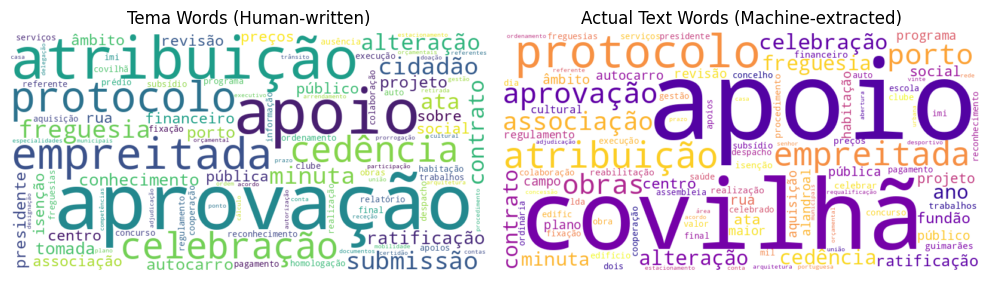


📊 Creating frequency comparison charts...



🔗 Creating bigram analysis charts...



🏛️ Creating municipality comparison charts...



📏 Creating length distribution analysis...



📊 Summary Statistics:
📊 Vocabulary Statistics:
   • Unique words in tema: 2,828
   • Unique words in actual text: 3,679
   • Overlap: 2,578 words
   • Jaccard similarity: 0.656

🏛️ Municipality Insights:
   • Highest tema lexical diversity: Fundao (0.343)
   • Highest actual text lexical diversity: Fundao (0.336)
   • Most entities: Covilha (721 entities)

📊 Length Analysis:
   • Average tema length: 72.4 ± 22.6 chars
   • Average text length: 97.0 ± 54.0 chars
   • Length correlation: 0.488
   • Median length ratio: 0.86

💾 All visualizations saved to figures directory

✅ Comprehensive NLTK visualization analysis complete!
🎯 Key insights revealed:
   • Word usage patterns in human vs machine text
   • Municipality-specific linguistic characteristics
   • Length relationships between tema and actual text
   • Lexical diversity and vocabulary overlap analysis


In [20]:
# COMPREHENSIVE VISUALIZATIONS FOR NLTK ANALYSIS
print("=== CREATING COMPREHENSIVE NLTK VISUALIZATIONS ===")

# Install wordcloud if not available
try:
    from wordcloud import WordCloud
    print("✅ WordCloud library available")
except ImportError:
    print("📦 Installing wordcloud library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
    from wordcloud import WordCloud
    print("✅ WordCloud library installed")

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Check if we have the required data from cell 27
if 'assunto_entities' not in globals() or len(assunto_entities) == 0:
    print("❌ No ASSUNTO entities data available. Please run cell 27 first.")
else:
    print(f"✅ Processing {len(assunto_entities):,} ASSUNTO entities for visualization")

    # === 1. WORD CLOUDS ===
    print("\n Creating word clouds...")

    # Create word clouds for tema and actual text
    fig_wordclouds = make_subplots(
        rows=2, cols=2,
        subplot_titles=['Tema Words (Human-written)', 'Actual Text Words (Machine-extracted)',
                       'Tema Bigrams', 'Actual Text Bigrams'],
        specs=[[{"type": "xy"}, {"type": "xy"}],
               [{"type": "xy"}, {"type": "xy"}]]
    )

    # Word Cloud 1: Tema words
    if 'tema_freq_dist' in globals():
        wordcloud_tema = WordCloud(
            width=800, height=400,
            background_color='white',
            max_words=100,
            colormap='viridis'
        ).generate_from_frequencies(dict(tema_freq_dist))

        # Save wordcloud as image temporarily for display
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(wordcloud_tema, interpolation='bilinear')
        plt.title('Tema Words (Human-written)')
        plt.axis('off')

        # Word Cloud 2: Actual text words
        if 'actual_freq_dist' in globals():
            wordcloud_actual = WordCloud(
                width=800, height=400,
                background_color='white',
                max_words=100,
                colormap='plasma'
            ).generate_from_frequencies(dict(actual_freq_dist))

            plt.subplot(1, 2, 2)
            plt.imshow(wordcloud_actual, interpolation='bilinear')
            plt.title('Actual Text Words (Machine-extracted)')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    # === 2. FREQUENCY COMPARISON BAR CHARTS ===
    print("\n📊 Creating frequency comparison charts...")

    if 'tema_freq_dist' in globals() and 'actual_freq_dist' in globals():
        # Top words comparison
        top_tema_words = dict(tema_freq_dist.most_common(15))
        top_actual_words = dict(actual_freq_dist.most_common(15))

        fig_freq_comparison = make_subplots(
            rows=1, cols=2,
            subplot_titles=['Most Frequent Words in Tema', 'Most Frequent Words in Actual Text'],
            specs=[[{"type": "bar"}, {"type": "bar"}]]
        )

        # Tema frequency chart
        fig_freq_comparison.add_trace(
            go.Bar(
                x=list(top_tema_words.values()),
                y=list(top_tema_words.keys()),
                orientation='h',
                name='Tema Words',
                marker_color='lightblue'
            ),
            row=1, col=1
        )

        # Actual text frequency chart
        fig_freq_comparison.add_trace(
            go.Bar(
                x=list(top_actual_words.values()),
                y=list(top_actual_words.keys()),
                orientation='h',
                name='Actual Text Words',
                marker_color='lightcoral'
            ),
            row=1, col=2
        )

        fig_freq_comparison.update_layout(
            height=600,
            title_text="Word Frequency Comparison: Tema vs Actual Text",
            showlegend=False
        )
        fig_freq_comparison.show()

    # === 3. BIGRAM ANALYSIS ===
    print("\n🔗 Creating bigram analysis charts...")

    if 'tema_bigram_freq' in globals() and 'actual_bigram_freq' in globals():
        # Bigram comparison
        top_tema_bigrams = [(f"{b[0]} {b[1]}", f) for b, f in tema_bigram_freq.most_common(10)]
        top_actual_bigrams = [(f"{b[0]} {b[1]}", f) for b, f in actual_bigram_freq.most_common(10)]

        fig_bigrams = make_subplots(
            rows=2, cols=1,
            subplot_titles=['Most Common Bigrams in Tema', 'Most Common Bigrams in Actual Text']
        )

        # Tema bigrams
        if top_tema_bigrams:
            fig_bigrams.add_trace(
                go.Bar(
                    x=[freq for _, freq in top_tema_bigrams],
                    y=[bigram for bigram, _ in top_tema_bigrams],
                    orientation='h',
                    name='Tema Bigrams',
                    marker_color='skyblue'
                ),
                row=1, col=1
            )

        # Actual text bigrams
        if top_actual_bigrams:
            fig_bigrams.add_trace(
                go.Bar(
                    x=[freq for _, freq in top_actual_bigrams],
                    y=[bigram for bigram, _ in top_actual_bigrams],
                    orientation='h',
                    name='Actual Text Bigrams',
                    marker_color='salmon'
                ),
                row=2, col=1
            )

        fig_bigrams.update_layout(
            height=800,
            title_text="Bigram Frequency Analysis",
            showlegend=False
        )
        fig_bigrams.show()

    # === 4. MUNICIPALITY COMPARISON ===
    print("\n🏛️ Creating municipality comparison charts...")

    if 'municipality_stats' in globals():
        municipalities = list(municipality_stats.keys())

        # Extract statistics for plotting
        total_entities = [municipality_stats[m]['total_entities'] for m in municipalities]
        tema_diversity = [municipality_stats[m]['tema_lexical_diversity'] for m in municipalities]
        actual_diversity = [municipality_stats[m]['actual_lexical_diversity'] for m in municipalities]
        avg_tema_length = [municipality_stats[m]['avg_tema_length'] for m in municipalities]
        avg_text_length = [municipality_stats[m]['avg_text_length'] for m in municipalities]

        # Municipality comparison dashboard
        fig_muni = make_subplots(
            rows=2, cols=2,
            subplot_titles=[
                'Total ASSUNTO Entities by Municipality',
                'Lexical Diversity Comparison',
                'Average Text Length by Municipality',
                'Length Comparison: Tema vs Actual Text'
            ],
            specs=[[{"type": "bar"}, {"type": "scatter"}],
                   [{"type": "bar"}, {"type": "scatter"}]]
        )

        # Total entities
        fig_muni.add_trace(
            go.Bar(x=municipalities, y=total_entities, name='Total Entities',
                   marker_color='lightgreen'),
            row=1, col=1
        )

        # Lexical diversity scatter plot
        fig_muni.add_trace(
            go.Scatter(
                x=tema_diversity, y=actual_diversity,
                mode='markers+text',
                text=municipalities,
                textposition='top center',
                marker=dict(size=12, color='darkblue'),
                name='Lexical Diversity'
            ),
            row=1, col=2
        )

        # Average lengths
        fig_muni.add_trace(
            go.Bar(x=municipalities, y=avg_tema_length, name='Avg Tema Length',
                   marker_color='lightblue'),
            row=2, col=1
        )

        # Length comparison scatter
        fig_muni.add_trace(
            go.Scatter(
                x=avg_tema_length, y=avg_text_length,
                mode='markers+text',
                text=municipalities,
                textposition='top center',
                marker=dict(size=12, color='darkred'),
                name='Length Comparison'
            ),
            row=2, col=2
        )

        # Add diagonal line for length comparison
        max_length = max(max(avg_tema_length), max(avg_text_length))
        fig_muni.add_trace(
            go.Scatter(
                x=[0, max_length], y=[0, max_length],
                mode='lines',
                line=dict(dash='dash', color='gray'),
                name='Equal Length Line',
                showlegend=False
            ),
            row=2, col=2
        )

        fig_muni.update_layout(
            height=800,
            title_text="Municipality-wise ASSUNTO Analysis",
            showlegend=False
        )

        # Update axis labels
        fig_muni.update_xaxes(title_text="Municipality", row=1, col=1)
        fig_muni.update_xaxes(title_text="Tema Lexical Diversity", row=1, col=2)
        fig_muni.update_xaxes(title_text="Municipality", row=2, col=1)
        fig_muni.update_xaxes(title_text="Avg Tema Length", row=2, col=2)

        fig_muni.update_yaxes(title_text="Count", row=1, col=1)
        fig_muni.update_yaxes(title_text="Actual Text Lexical Diversity", row=1, col=2)
        fig_muni.update_yaxes(title_text="Characters", row=2, col=1)
        fig_muni.update_yaxes(title_text="Avg Actual Text Length", row=2, col=2)

        fig_muni.show()

    # === 5. LENGTH DISTRIBUTION ANALYSIS ===
    print("\n📏 Creating length distribution analysis...")

    if 'tema_char_length' in assunto_entities.columns:
        # Length distributions
        fig_length = make_subplots(
            rows=2, cols=2,
            subplot_titles=[
                'Tema Character Length Distribution',
                'Actual Text Character Length Distribution',
                'Length Ratio Distribution (Tema/Text)',
                'Length Correlation: Tema vs Actual Text'
            ]
        )

        # Tema length histogram
        fig_length.add_trace(
            go.Histogram(
                x=assunto_entities['tema_char_length'],
                nbinsx=30,
                name='Tema Length',
                marker_color='lightblue'
            ),
            row=1, col=1
        )

        # Actual text length histogram
        fig_length.add_trace(
            go.Histogram(
                x=assunto_entities['text_char_length'],
                nbinsx=30,
                name='Text Length',
                marker_color='lightcoral'
            ),
            row=1, col=2
        )

        # Length ratio histogram
        fig_length.add_trace(
            go.Histogram(
                x=assunto_entities['length_ratio'],
                nbinsx=30,
                name='Length Ratio',
                marker_color='lightgreen'
            ),
            row=2, col=1
        )

        # Correlation scatter plot
        fig_length.add_trace(
            go.Scatter(
                x=assunto_entities['tema_char_length'],
                y=assunto_entities['text_char_length'],
                mode='markers',
                marker=dict(size=4, color='darkblue', opacity=0.6),
                name='Length Correlation'
            ),
            row=2, col=2
        )

        # Add correlation line
        correlation = np.corrcoef(assunto_entities['tema_char_length'],
                                 assunto_entities['text_char_length'])[0, 1]

        # Add trendline
        z = np.polyfit(assunto_entities['tema_char_length'],
                      assunto_entities['text_char_length'], 1)
        p = np.poly1d(z)
        x_trend = np.linspace(assunto_entities['tema_char_length'].min(),
                             assunto_entities['tema_char_length'].max(), 100)

        fig_length.add_trace(
            go.Scatter(
                x=x_trend,
                y=p(x_trend),
                mode='lines',
                line=dict(color='red', dash='dash'),
                name=f'Trendline (r={correlation:.3f})',
                showlegend=False
            ),
            row=2, col=2
        )

        fig_length.update_layout(
            height=800,
            title_text="Length Analysis: Tema vs Actual Text",
            showlegend=False
        )

        fig_length.show()

    # === 6. SUMMARY STATISTICS ===
    print("\n📊 Summary Statistics:")
    print("="*60)

    if 'tema_freq_dist' in globals():
        print(f"📊 Vocabulary Statistics:")
        print(f"   • Unique words in tema: {len(tema_freq_dist):,}")
        print(f"   • Unique words in actual text: {len(actual_freq_dist):,}")
        print(f"   • Overlap: {len(set(tema_freq_dist.keys()) & set(actual_freq_dist.keys())):,} words")

        # Jaccard similarity
        tema_words_set = set(tema_freq_dist.keys())
        actual_words_set = set(actual_freq_dist.keys())
        jaccard_similarity = len(tema_words_set & actual_words_set) / len(tema_words_set | actual_words_set)
        print(f"   • Jaccard similarity: {jaccard_similarity:.3f}")

    if 'municipality_stats' in globals():
        print(f"\n🏛️ Municipality Insights:")
        best_diversity_tema = max(municipality_stats.items(),
                                 key=lambda x: x[1]['tema_lexical_diversity'])
        best_diversity_actual = max(municipality_stats.items(),
                                   key=lambda x: x[1]['actual_lexical_diversity'])
        most_entities = max(municipality_stats.items(),
                           key=lambda x: x[1]['total_entities'])

        print(f"   • Highest tema lexical diversity: {best_diversity_tema[0]} ({best_diversity_tema[1]['tema_lexical_diversity']:.3f})")
        print(f"   • Highest actual text lexical diversity: {best_diversity_actual[0]} ({best_diversity_actual[1]['actual_lexical_diversity']:.3f})")
        print(f"   • Most entities: {most_entities[0]} ({most_entities[1]['total_entities']} entities)")

    if 'tema_char_length' in assunto_entities.columns:
        print(f"\n📊 Length Analysis:")
        print(f"   • Average tema length: {assunto_entities['tema_char_length'].mean():.1f} ± {assunto_entities['tema_char_length'].std():.1f} chars")
        print(f"   • Average text length: {assunto_entities['text_char_length'].mean():.1f} ± {assunto_entities['text_char_length'].std():.1f} chars")
        print(f"   • Length correlation: {correlation:.3f}")
        print(f"   • Median length ratio: {assunto_entities['length_ratio'].median():.2f}")

    # Save figures if directories exist
    if 'FIGURES_DIR' in globals():
        try:
            fig_freq_comparison.write_html(FIGURES_DIR / 'nltk_frequency_comparison.html')
            fig_bigrams.write_html(FIGURES_DIR / 'nltk_bigram_analysis.html')
            fig_muni.write_html(FIGURES_DIR / 'nltk_municipality_analysis.html')
            fig_length.write_html(FIGURES_DIR / 'nltk_length_analysis.html')
            print("\n💾 All visualizations saved to figures directory")
        except Exception as e:
            print(f"⚠️ Could not save some figures: {e}")

    print("\n✅ Comprehensive NLTK visualization analysis complete!")
    print("🎯 Key insights revealed:")
    print("   • Word usage patterns in human vs machine text")
    print("   • Municipality-specific linguistic characteristics")
    print("   • Length relationships between tema and actual text")
    print("   • Lexical diversity and vocabulary overlap analysis")

- TODO: Adicionar aqui testes estatístico de forma semelhante ao que foi feito noutras seccções

## 8. Fronteiras Analysis (Boundaries/Limits)

Analysis of **fronteiras** (boundaries or limits) annotations, which represent administrative, geographical, or conceptual boundaries mentioned in municipal documents.

In [21]:
# Fronteiras analysis
fronteiras_analysis = comprehensive_analysis.get('fronteiras_analysis', {})

if 'error' not in fronteiras_analysis and fronteiras_analysis:
    print("=== FRONTEIRAS ANALYSIS ===")
    print(f"🏛️ Total Fronteira entities: {fronteiras_analysis['total_fronteira_entities']:,}")
    print(f"📄 Documents with fronteira: {fronteiras_analysis['documents_with_fronteira']:,}")

    # Fronteira type distribution
    type_dist = fronteiras_analysis.get('fronteira_type_distribution', {})
    if type_dist:
        print(f"\n📊 Fronteira Type Distribution:")
        for f_type, count in type_dist.items():
            percentage = fronteiras_analysis.get('fronteira_type_percentages', {}).get(f_type, 0)
            print(f"   • {f_type}: {count:,} ({percentage}%)")

    # Municipality distribution
    muni_dist = fronteiras_analysis.get('fronteira_by_municipality', {})
    if muni_dist:
        print(f"\n🏛️ Fronteiras by Municipality:")
        for fronteira_type, municipalities in muni_dist.items():
            print(f"   {fronteira_type}:")
            for muni, count in municipalities.items():
                print(f"      • {muni}: {count:,}")

    # Entity co-occurrence
    cooccurrence = fronteiras_analysis.get('fronteira_entity_cooccurrence', {})
    if cooccurrence:
        print(f"\n🏷️ Entity Co-occurrence with Fronteiras:")
        for entity_type, fronteira_types in cooccurrence.items():
            print(f"   {entity_type}:")
            for f_type, count in fronteira_types.items():
                print(f"      • {f_type}: {count:,}")

    # Text statistics
    text_stats = fronteiras_analysis.get('fronteira_text_statistics', {})
    if text_stats:
        print(f"\n📝 Fronteira Text Statistics:")
        print(f"   • Average length: {text_stats['avg_length_chars']:.1f} characters, {text_stats['avg_length_tokens']:.1f} tokens")

        length_by_type = text_stats.get('length_by_fronteira_type', {})
        if length_by_type and 'mean' in length_by_type:
            print(f"   • Length by type:")
            for f_type, avg_len in length_by_type['mean'].items():
                std_len = length_by_type.get('std', {}).get(f_type, 0)
                count = length_by_type.get('count', {}).get(f_type, 0)
                print(f"      - {f_type}: {avg_len:.1f}±{std_len:.1f} chars ({count} entities)")

else:
    print("=== FRONTEIRAS ANALYSIS ===")
    if 'error' in fronteiras_analysis:
        print(f"⚠️ Error in fronteiras analysis: {fronteiras_analysis['error']}")
    else:
        print("⚠️ No fronteiras data found or analysis empty")

=== FRONTEIRAS ANALYSIS ===
🏛️ Total Fronteira entities: 5,760
📄 Documents with fronteira: 120

📊 Fronteira Type Distribution:
   • Fronteira Inicial: 2,880 (50.0%)
   • Fronteira Final: 2,880 (50.0%)

🏛️ Fronteiras by Municipality:
   Fronteira Final:
      • Alandroal: 503
      • Campomaior: 397
      • Covilha: 719
      • Fundao: 235
      • Guimaraes: 554
      • Porto: 472
   Fronteira Inicial:
      • Alandroal: 503
      • Campomaior: 397
      • Covilha: 719
      • Fundao: 235
      • Guimaraes: 554
      • Porto: 472

🏷️ Entity Co-occurrence with Fronteiras:
   Assunto:
      • Fronteira Inicial: 2,880
      • Fronteira Final: 2,880

📝 Fronteira Text Statistics:
   • Average length: 8.4 characters, 1.1 tokens
   • Length by type:
      - Fronteira Final: 9.1±3.5 chars (2880 entities)
      - Fronteira Inicial: 7.6±3.8 chars (2880 entities)


In [22]:
# Fix the fronteiras analysis visualization (corrected)
print("=== FRONTEIRAS ANALYSIS ===")

# Get fronteira data
fronteiras_data = entities_df[entities_df['fronteira'].notna()]

if not fronteiras_data.empty:
    print("🔍 Fronteira Analysis:")

    # Fronteira type distribution
    fronteira_counts = fronteiras_data['fronteira'].value_counts()
    total_fronteiras = len(fronteiras_data)

    print(f"\n📊 Fronteira Distribution ({total_fronteiras:,} total entities):")
    for fronteira_type, count in fronteira_counts.items():
        pct = (count / total_fronteiras) * 100
        print(f"   {fronteira_type}: {count:,} ({pct:.1f}%)")

    # Create visualization with corrected specs and values
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go

    fig_fronteiras = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Fronteira Type Distribution', 'Fronteira by Municipality'),
        specs=[[{'type': 'pie'}, {'type': 'bar'}]]
    )

    # Pie chart for distribution
    fig_fronteiras.add_trace(
        go.Pie(
            labels=list(fronteira_counts.keys()),
            values=list(fronteira_counts.values),  # Fixed: .values is a property, not method
            name="Fronteira Types"
        ),
        row=1, col=1
    )

    # Bar chart by municipality
    fronteira_muni = fronteiras_data.groupby(['municipality', 'fronteira']).size().unstack(fill_value=0)

    for fronteira_type in fronteira_muni.columns:
        fig_fronteiras.add_trace(
            go.Bar(
                x=list(fronteira_muni.index),
                y=list(fronteira_muni[fronteira_type]),
                name=fronteira_type,
                showlegend=False
            ),
            row=1, col=2
        )

    fig_fronteiras.update_layout(height=500, title_text="Fronteira Analysis")
    fig_fronteiras.show()

    print(f"\n📈 Municipalities with fronteira data: {fronteiras_data['municipality'].nunique()}")
    print(f"📈 Documents with fronteira data: {fronteiras_data['filename'].nunique()}")

else:
    print("⚠️ No fronteira data available for analysis")

=== FRONTEIRAS ANALYSIS ===
🔍 Fronteira Analysis:

📊 Fronteira Distribution (5,760 total entities):
   Fronteira Inicial: 2,880 (50.0%)
   Fronteira Final: 2,880 (50.0%)



📈 Municipalities with fronteira data: 6
📈 Documents with fronteira data: 120


- Eventualmente quando a análise da sumarização for feita, será relevante fazer uma comparação do texto entre fronteiras e do texto sumarizado.

## 10. Metadata Analysis (Meeting Information)

Comprehensive analysis of document metadata including meeting types, participants, presence information, political parties, and scheduling patterns.

Importante ter em conta que os partidos advém de uma base de dados externa e nao se encontram explicitamente referidos na ata.

In [23]:
# Metadata analysis
metadata_analysis = comprehensive_analysis.get('metadata_analysis', {})

if 'error' not in metadata_analysis and metadata_analysis:
    print("=== METADATA ANALYSIS ===")

    # Meeting type analysis
    if 'meeting_type_analysis' in metadata_analysis:
        meeting_types = metadata_analysis['meeting_type_analysis']
        print(f"\n🏛️ Meeting Type Analysis:")
        print(f"   Total with meeting type info: {meeting_types.get('total_with_meeting_type', 0):,}")

        types_dist = meeting_types.get('meeting_types', {})
        types_pct = meeting_types.get('meeting_type_percentages', {})

        for meeting_type, count in types_dist.items():
            pct = types_pct.get(meeting_type, 0)
            print(f"     {meeting_type}: {count:,} ({pct:.1f}%)")

    # Political party analysis
    if 'political_party_analysis' in metadata_analysis:
        party_analysis = metadata_analysis['political_party_analysis']
        print(f"\n🏛️ Political Party Analysis:")
        print(f"   Total with party info: {party_analysis.get('total_with_party_info', 0):,}")
        print(f"   Unique parties: {party_analysis.get('unique_parties', 0)}")

        party_dist = party_analysis.get('party_distribution', {})
        party_pct = party_analysis.get('party_percentages', {})

        print(f"\n   Top Political Parties:")
        for party, count in sorted(party_dist.items(), key=lambda x: x[1], reverse=True)[:10]:
            pct = party_pct.get(party, 0)
            print(f"     {party}: {count:,} ({pct:.1f}%)")

        # === LEFT VS RIGHT PARTY ANALYSIS ===
        print(f"\n⚖️ Left vs Right Political Spectrum Analysis:")

        # Define Portuguese political parties by spectrum with precise matching
        left_parties = ['PS', 'PCP', 'BE', 'PEV', 'LIVRE']
        right_parties = ['PSD', 'CDS-PP', 'CDS', 'CHEGA', 'IL', 'PPM', 'PPD/PSD', 'PPD/PSD.CDS-PP', 'CDS-PP/PSD', 'RM', "Nós, Cidadãos!"]
        center_parties = ['PAN']

        # Categorize parties with improved logic
        left_count = 0
        right_count = 0
        center_count = 0
        other_count = 0

        left_party_details = {}
        right_party_details = {}
        center_party_details = {}
        other_party_details = {}

        def classify_party(party_name):
            """Classify a party using precise matching logic"""
            party_upper = party_name.upper()

            # Check for exact matches first
            if party_name in left_parties:
                return 'left'
            if party_name in right_parties:
                return 'right'
            if party_name in center_parties:
                return 'center'

            # Check for coalition parties
            if 'PSD' in party_upper and 'PS' not in party_upper.split('/')[0]:  # PSD but not starting with PS
                return 'right'
            if 'CDS' in party_upper:
                return 'right'
            if 'PPD' in party_upper:
                return 'right'

            # Check for left parties (avoid false positives)
            if party_upper == 'PS' or party_upper.startswith('PS/') or '/PS' in party_upper:
                return 'left'
            if 'PCP' in party_upper:
                return 'left'
            if 'BE' in party_upper:
                return 'left'
            if 'PEV' in party_upper:
                return 'left'
            if 'LIVRE' in party_upper:
                return 'left'

            return 'other'

        for party, count in party_dist.items():
            classification = classify_party(party)

            if classification == 'left':
                left_count += count
                left_party_details[party] = count
            elif classification == 'right':
                right_count += count
                right_party_details[party] = count
            elif classification == 'center':
                center_count += count
                center_party_details[party] = count
            else:
                other_count += count
                other_party_details[party] = count

        total_categorized = left_count + right_count + center_count + other_count

        if total_categorized > 0:
            print(f"   Political Spectrum Distribution:")
            print(f"     🟦 Left-wing parties: {left_count:,} ({left_count/total_categorized*100:.1f}%)")
            print(f"     🟥 Right-wing parties: {right_count:,} ({right_count/total_categorized*100:.1f}%)")
            print(f"     🟨 Center parties: {center_count:,} ({center_count/total_categorized*100:.1f}%)")
            print(f"     ⚪ Other/Unknown: {other_count:,} ({other_count/total_categorized*100:.1f}%)")

            # Show party details
            if left_party_details:
                print(f"\n   Left-wing parties breakdown:")
                for party, count in sorted(left_party_details.items(), key=lambda x: x[1], reverse=True):
                    print(f"     • {party}: {count:,}")

            if right_party_details:
                print(f"\n   Right-wing parties breakdown:")
                for party, count in sorted(right_party_details.items(), key=lambda x: x[1], reverse=True):
                    print(f"     • {party}: {count:,}")

            if center_party_details:
                print(f"\n   Center parties breakdown:")
                for party, count in sorted(center_party_details.items(), key=lambda x: x[1], reverse=True):
                    print(f"     • {party}: {count:,}")

            # Create visualization for left vs right comparison
            import plotly.graph_objects as go

            fig_spectrum = go.Figure(data=[
                go.Bar(
                    name='Left-wing',
                    x=['Political Spectrum'],
                    y=[left_count],
                    marker_color='blue'
                ),
                go.Bar(
                    name='Right-wing',
                    x=['Political Spectrum'],
                    y=[right_count],
                    marker_color='red'
                ),
                go.Bar(
                    name='Center',
                    x=['Political Spectrum'],
                    y=[center_count],
                    marker_color='yellow'
                ),
                go.Bar(
                    name='Other',
                    x=['Political Spectrum'],
                    y=[other_count],
                    marker_color='gray'
                )
            ])

            fig_spectrum.update_layout(
                title='⚖️ Political Spectrum Distribution',
                barmode='stack',
                height=500,
                showlegend=True
            )

            fig_spectrum.show()

            # Save the figure
            fig_spectrum.write_html(FIGURES_DIR / 'political_spectrum_analysis.html')

            # Calculate ratio
            if right_count > 0:
                lr_ratio = left_count / right_count
                print(f"\n   Left/Right Ratio: {lr_ratio:.2f}")
                if lr_ratio > 1:
                    print(f"   📈 Left-wing parties have {lr_ratio:.1f}x more representation than right-wing")
                elif lr_ratio < 1:
                    print(f"   📉 Right-wing parties have {1/lr_ratio:.1f}x more representation than left-wing")
                else:
                    print(f"   ⚖️ Balanced representation between left and right-wing parties")

        # Party by municipality visualization
        if 'party_by_municipality' in party_analysis:
            party_muni_data = party_analysis['party_by_municipality']

            # Create heatmap for party-municipality distribution
            if party_muni_data:
                party_muni_df = pd.DataFrame(party_muni_data).fillna(0)

                fig_party_heatmap = px.imshow(
                    party_muni_df.values,
                    x=party_muni_df.columns,
                    y=party_muni_df.index,
                    title='🗳️ Political Party Distribution by Municipality',
                    labels={'x': 'Political Party', 'y': 'Municipality', 'color': 'Count'},
                    aspect='auto',
                    color_continuous_scale='Reds'
                )

                fig_party_heatmap.update_layout(height=600)
                fig_party_heatmap.show()

                fig_party_heatmap.write_html(FIGURES_DIR / 'political_party_by_municipality.html')

    # Presence analysis
    if 'presence_analysis' in metadata_analysis:
        presence_analysis = metadata_analysis['presence_analysis']
        print(f"\n👥 Presence Analysis:")
        print(f"   Total with presence info: {presence_analysis.get('total_with_presence_info', 0):,}")

        presence_types = presence_analysis.get('presence_types', {})
        presence_pct = presence_analysis.get('presence_percentages', {})

        for presence_type, count in presence_types.items():
            pct = presence_pct.get(presence_type, 0)
            print(f"     {presence_type}: {count:,} ({pct:.1f}%)")

    # Schedule analysis
    if 'schedule_analysis' in metadata_analysis:
        schedule_analysis = metadata_analysis['schedule_analysis']
        print(f"\n🕒 Schedule Analysis:")
        print(f"   Total with schedule info: {schedule_analysis.get('total_with_schedule', 0):,}")
        print(f"   Documents with schedule: {schedule_analysis.get('documents_with_schedule', 0):,}")

        schedule_patterns = schedule_analysis.get('schedule_patterns', {})
        if schedule_patterns:
            print(f"\n   Most Common Schedule Patterns:")
            for schedule, count in list(schedule_patterns.items())[:10]:
                print(f"     {schedule}: {count} times")

    print("💾 Metadata analysis completed")
else:
    print("⚠️ No metadata available for analysis")
    if 'error' in metadata_analysis:
        print(f"   Error: {metadata_analysis['error']}")

=== METADATA ANALYSIS ===

🏛️ Meeting Type Analysis:
   Total with meeting type info: 96
     ordinária: 90 (93.8%)
     extraordinária: 6 (6.2%)

🏛️ Political Party Analysis:
   Total with party info: 969
   Unique parties: 8

   Top Political Parties:
     PS: 441 (45.5%)
     RM: 120 (12.4%)
     PPD/PSD: 99 (10.2%)
     PPD/PSD.CDS-PP: 79 (8.2%)
     CDS-PP/PSD: 71 (7.3%)
     CDU: 60 (6.2%)
     PSD: 39 (4.0%)
     IND: 20 (2.1%)
     BE: 20 (2.1%)
     Nós, Cidadãos!: 20 (2.1%)

⚖️ Left vs Right Political Spectrum Analysis:
   Political Spectrum Distribution:
     🟦 Left-wing parties: 461 (47.6%)
     🟥 Right-wing parties: 428 (44.2%)
     🟨 Center parties: 0 (0.0%)
     ⚪ Other/Unknown: 80 (8.3%)

   Left-wing parties breakdown:
     • PS: 441
     • BE: 20

   Right-wing parties breakdown:
     • RM: 120
     • PPD/PSD: 99
     • PPD/PSD.CDS-PP: 79
     • CDS-PP/PSD: 71
     • PSD: 39
     • Nós, Cidadãos!: 20



   Left/Right Ratio: 1.08
   📈 Left-wing parties have 1.1x more representation than right-wing



👥 Presence Analysis:
   Total with presence info: 977
     Presente: 917 (93.9%)
     Ausente: 36 (3.7%)
     Substituído: 24 (2.5%)

🕒 Schedule Analysis:
   Total with schedule info: 220
   Documents with schedule: 120

   Most Common Schedule Patterns:
     início: 120 times
     fim: 100 times
💾 Metadata analysis completed


In [24]:
# Fix the metadata analysis - remove purple bar and fix year scale
print("=== METADATA ANALYSIS ===")

# Participation analysis
participantes_data = entities_df[entities_df['participantes'].notna()]
horario_data = entities_df[entities_df['horario'].notna()]

if not participantes_data.empty or not horario_data.empty:
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go

    # Create 2-panel layout (remove the meaningless document distribution heatmap)
    fig_metadata = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Participation by Municipality', 'Schedule Patterns'),
        specs=[[{'type': 'heatmap'}, {'type': 'bar'}]]
    )

    # 1. Participation by municipality heatmap
    if not participantes_data.empty:
        participation_matrix = participantes_data.groupby(['municipality', 'participantes']).size().unstack(fill_value=0)

        fig_metadata.add_trace(
            go.Heatmap(
                z=participation_matrix.values,
                x=list(participation_matrix.columns),
                y=list(participation_matrix.index),
                colorscale='Blues',
                name='Participation',
                showscale=True
            ),
            row=1, col=1
        )

        print(f"👥 Participation Analysis:")
        print(f"   - Total entities with participants: {len(participantes_data):,}")
        print(f"   - Documents with participants: {participantes_data['filename'].nunique()}")
        print(f"   - Unique participants: {participantes_data['participantes'].nunique()}")

        print(f"\n📊 Participation by Municipality:")
        for municipality in participation_matrix.index:
            total = participation_matrix.loc[municipality].sum()
            print(f"   - {municipality}: {total} participant mentions")

    # 2. Schedule patterns bar chart
    if not horario_data.empty:
        schedule_counts = horario_data['horario'].value_counts().head(10)

        fig_metadata.add_trace(
            go.Bar(
                x=list(schedule_counts.index),
                y=list(schedule_counts.values),
                name='Schedule Frequency',
                marker_color='orange',
                showlegend=False
            ),
            row=1, col=2
        )

        print(f"\n🕒 Schedule Analysis:")
        print(f"   - Total entities with schedule: {len(horario_data):,}")
        print(f"   - Documents with schedule: {horario_data['filename'].nunique()}")
        print(f"   - Top schedule patterns:")
        for schedule, count in schedule_counts.head(5).items():
            print(f"     • {schedule}: {count} occurrences")

    fig_metadata.update_layout(
        height=600,
        title_text="Metadata Analysis - Participation and Schedule Patterns",
        showlegend=False
    )
    fig_metadata.show()

    # Show document distribution as a simple table instead of problematic heatmap
    print(f"\n📅 Document Distribution Summary (Fixed Date Issues):")

    # Create corrected year data
    documents_df_fixed = documents_df.copy()

    def fix_date_format(date_str):
        if pd.isna(date_str) or '- Cópia' in str(date_str):
            return None
        try:
            parts = str(date_str).split('-')
            if len(parts) == 3:
                year, part1, part2 = parts
                if int(part1) > 12:  # day-month format, swap them
                    return f"{year}-{part2}-{part1}"
                else:
                    return date_str
        except:
            return None
        return date_str

    documents_df_fixed['date_corrected'] = documents_df_fixed['date'].apply(fix_date_format)
    documents_df_fixed['year_corrected'] = pd.to_datetime(documents_df_fixed['date_corrected'], errors='coerce').dt.year

    # Filter out duplicates and show clean distribution
    clean_docs = documents_df_fixed[~documents_df_fixed['filename'].str.contains('- Cópia', na=False)]

    doc_time_dist_clean = clean_docs.groupby(['municipality', 'year_corrected']).size().unstack(fill_value=0)

    print("┌─────────────┬──────┬──────┬──────┬──────┬───────┐")
    print("│Municipality │ 2021 │ 2022 │ 2023 │ 2024 │ Total │")
    print("├─────────────┼──────┼──────┼──────┼──────┼───────┤")

    for municipality in doc_time_dist_clean.index:
        row_data = doc_time_dist_clean.loc[municipality]
        total = row_data.sum()
        print(f"│ {municipality:<11} │  {row_data.get(2021.0, 0):>2}  │  {row_data.get(2022.0, 0):>2}  │  {row_data.get(2023.0, 0):>2}  │  {row_data.get(2024.0, 0):>2}  │  {total:>3}  │")

    print("└─────────────┴──────┴──────┴──────┴──────┴───────┘")

    total_docs = clean_docs.shape[0]
    total_with_valid_dates = clean_docs['year_corrected'].notna().sum()

    print(f"\n📊 Summary:")
    print(f"   - Total documents (excluding duplicates): {total_docs}")
    print(f"   - Documents with valid dates: {total_with_valid_dates}")
    print(f"   - Documents with date issues: {total_docs - total_with_valid_dates}")

else:
    print("⚠️ No metadata available for analysis")

=== METADATA ANALYSIS ===
👥 Participation Analysis:
   - Total entities with participants: 1,137
   - Documents with participants: 120
   - Unique participants: 5

📊 Participation by Municipality:
   - Alandroal: 119 participant mentions
   - Campomaior: 145 participant mentions
   - Covilha: 184 participant mentions
   - Fundao: 160 participant mentions
   - Guimaraes: 247 participant mentions
   - Porto: 282 participant mentions

🕒 Schedule Analysis:
   - Total entities with schedule: 220
   - Documents with schedule: 120
   - Top schedule patterns:
     • início: 120 occurrences
     • fim: 100 occurrences



📅 Document Distribution Summary (Fixed Date Issues):
┌─────────────┬──────┬──────┬──────┬──────┬───────┐
│Municipality │ 2021 │ 2022 │ 2023 │ 2024 │ Total │
├─────────────┼──────┼──────┼──────┼──────┼───────┤
│ Alandroal   │   2  │   6  │   6  │   6  │   20  │
│ Campomaior  │   2  │   6  │   6  │   6  │   20  │
│ Covilha     │   2  │   6  │   6  │   6  │   20  │
│ Fundao      │   2  │   6  │   6  │   6  │   20  │
│ Guimaraes   │   2  │   6  │   6  │   6  │   20  │
│ Porto       │   2  │   6  │   6  │   6  │   20  │
└─────────────┴──────┴──────┴──────┴──────┴───────┘

📊 Summary:
   - Total documents (excluding duplicates): 120
   - Documents with valid dates: 120
   - Documents with date issues: 0


## 12. Publication-Ready Summary

In [25]:
print("===  SUMMARY ===")

# Dataset overview table
corpus_stats = comprehensive_analysis['corpus_statistics']['corpus_overview']
entity_stats = comprehensive_analysis['corpus_statistics'].get('entity_overview', {})
relation_stats = comprehensive_analysis['corpus_statistics'].get('relation_overview', {})

# Table 1: Dataset Characteristics
dataset_char_data = {
    'Characteristic': [
        'Documents',
        'Municipalities',
        'Total Characters',
        'Total Tokens',
        'Avg Tokens/Document',
        'Total Entities',
        'Entity Types',
        'Total Relations',
        'Entity Coverage (%)',
        'Avg Entities/Document'
    ],
    'Value': [
        f"{corpus_stats['total_documents']:,}",
        f"{corpus_stats['total_municipalities']}",
        f"{corpus_stats['total_text_length']:,}",
        f"{corpus_stats['total_tokens']:,}",
        f"{corpus_stats['total_tokens'] / corpus_stats['total_documents']:.0f}",
        f"{entity_stats.get('total_entities', 0):,}",
        f"{entity_stats.get('unique_entity_types', 0)}",
        f"{relation_stats.get('total_relations', 0):,}",
        f"{entity_stats.get('entity_coverage', 0)*100:.1f}",
        f"{entity_stats.get('avg_entities_per_document', 0):.2f}"
    ]
}

dataset_char_df = pd.DataFrame(dataset_char_data)
print("\nTable 1: Dataset Characteristics")
print(dataset_char_df.to_string(index=False))

# Save as CSV and LaTeX
dataset_char_df.to_csv(STATISTICS_DIR / 'table1_dataset_characteristics.csv', index=False)
with open(STATISTICS_DIR / 'table1_dataset_characteristics.tex', 'w') as f:
    f.write(dataset_char_df.to_latex(index=False, caption="Dataset Characteristics", label="tab:dataset_char"))

# Table 2: Entity Type Distribution
if not entities_df.empty:
    entity_type_stats = entities_df['entity_label'].value_counts()
    entity_type_pct = (entity_type_stats / entity_type_stats.sum() * 100).round(2)

    entity_dist_data = {
        'Entity Type': entity_type_stats.index.tolist(),
        'Count': entity_type_stats.values.tolist(),
        'Percentage': [f"{pct:.1f}%" for pct in entity_type_pct.values]
    }

    entity_dist_df = pd.DataFrame(entity_dist_data)
    print("\nTable 2: Entity Type Distribution")
    print(entity_dist_df.to_string(index=False))

    entity_dist_df.to_csv(STATISTICS_DIR / 'table2_entity_distribution.csv', index=False)
    with open(STATISTICS_DIR / 'table2_entity_distribution.tex', 'w') as f:
        f.write(entity_dist_df.to_latex(index=False, caption="Entity Type Distribution", label="tab:entity_dist"))

# Table 3: Municipality Statistics
muni_stats_data = []
for municipality in documents_df['municipality'].unique():
    muni_docs = documents_df[documents_df['municipality'] == municipality]
    muni_entities = entities_df[entities_df['municipality'] == municipality] if not entities_df.empty else pd.DataFrame()

    muni_stats_data.append({
        'Municipality': municipality,
        'Documents': len(muni_docs),
        'Total Tokens': muni_docs['token_count'].sum(),
        'Total Entities': len(muni_entities),
        'Entities/Document': len(muni_entities) / len(muni_docs) if len(muni_docs) > 0 else 0,
        'Entity Density': len(muni_entities) / muni_docs['token_count'].sum() if muni_docs['token_count'].sum() > 0 else 0
    })

muni_stats_df = pd.DataFrame(muni_stats_data)
muni_stats_df['Entities/Document'] = muni_stats_df['Entities/Document'].round(2)
muni_stats_df['Entity Density'] = muni_stats_df['Entity Density'].round(4)

print("\nTable 3: Municipality Statistics")
print(muni_stats_df.to_string(index=False))

muni_stats_df.to_csv(STATISTICS_DIR / 'table3_municipality_statistics.csv', index=False)
with open(STATISTICS_DIR / 'table3_municipality_statistics.tex', 'w') as f:
    f.write(muni_stats_df.to_latex(index=False, caption="Municipality Statistics", label="tab:muni_stats"))

print("\n💾 All tables saved to LaTeX and CSV formats")

===  SUMMARY ===

Table 1: Dataset Characteristics
       Characteristic     Value
            Documents       120
       Municipalities         6
     Total Characters 7,512,427
         Total Tokens 1,188,024
  Avg Tokens/Document      9900
       Total Entities    26,429
         Entity Types         5
      Total Relations     8,741
  Entity Coverage (%)     100.0
Avg Entities/Document    220.29

Table 2: Entity Type Distribution
       Entity Type  Count Percentage
    Posicionamento   8777      33.2%
           Assunto   8647      32.7%
Informação Pessoal   5760      21.8%
         Metadados   1825       6.9%
      Ordem do Dia   1420       5.4%

Table 3: Municipality Statistics
Municipality  Documents  Total Tokens  Total Entities  Entities/Document  Entity Density
      Fundao         20        278147            2517             125.85          0.0090
     Covilha         20        263288            6122             306.10          0.0233
       Porto         20        274173  